# Importing

In [1]:
import arviz as az
import numba 
from numba import jit, prange
import arviz as az
import numpy as np
import cmath
import math
from sympy.matrices import Matrix
from sympy.abc import f
import sympy as sp
import matplotlib.pyplot as plt
from sympy import symbols, Eq, solve
from sympy import simplify

import itertools
import emcee
import corner
# import scienceplots
# plt.style.use(['science','ieee','no-latex'])

from multiprocessing import Pool, cpu_count
import time
import os


import os
import PyPDF2
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Image, Paragraph, Spacer, PageBreak
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.units import inch
from datetime import datetime



actual_values = np.array([211.7, 42.7, 74.8, 36.65])

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams["font.size"] = "20"

# Automatic parameter input interface

In [2]:
import tkinter as tk
from tkinter import messagebox
import numpy as np

class MCMCApp:
    def __init__(self, master):
        self.master = master
        master.title("MCMC Parameter Input")

        # Initial Guess
        self.guess_label = tk.Label(master, text="Initial Guess:")
        self.guess_label.grid(row=0, column=0, padx=5, pady=5)

        # Initial guess entries
        initial_guess = [250, 250, 250, 250]
        self.guess_entries = []
        for i in range(4):
            entry = tk.Entry(master)
            entry.grid(row=0, column=i + 1, padx=5, pady=5)
            entry.insert(0, str(initial_guess[i]))
            self.guess_entries.append(entry)

        # Frequency Points
        self.freq_label = tk.Label(master, text="Frequency Points (GHz):")
        self.freq_label.grid(row=1, column=0, padx=5, pady=5)

        # Frequency points entries
        freq_points = [20, 25, 30]
        self.freq_entries = []
        for i in range(3):
            entry = tk.Entry(master)
            entry.grid(row=1, column=i + 1, padx=5, pady=5)
            entry.insert(0, str(freq_points[i]))
            self.freq_entries.append(entry)

        # Bounds
        self.bounds_label = tk.Label(master, text="Bounds:")
        self.bounds_label.grid(row=2, column=0, padx=5, pady=5)

        # Bounds entries
        bounds = [[0, 300], [0, 300], [0, 300], [0, 300]]
        self.bounds_entries = []
        for i in range(4):
            label = tk.Label(master, text=f"S{i + 1}1:")
            label.grid(row=3, column=i, padx=5, pady=5)

            entry_min = tk.Entry(master)
            entry_min.grid(row=4, column=i, padx=5, pady=5)
            entry_min.insert(0, str(bounds[i][0]))

            entry_max = tk.Entry(master)
            entry_max.grid(row=5, column=i, padx=5, pady=5)
            entry_max.insert(0, str(bounds[i][1]))

            self.bounds_entries.append((entry_min, entry_max))

        # S-Parameters
        self.s_param_label = tk.Label(master, text="S-Parameters:")
        self.s_param_label.grid(row=6, column=0, padx=5, pady=5)

        # S Values
        self.s_values_label = tk.Label(master, text="S Values:")
        self.s_values_label.grid(row=7, column=0, padx=5, pady=5)



        # S Error Tolerance
        self.s_error_label = tk.Label(master, text="S Error Tolerance:")
        self.s_error_label.grid(row=11, column=0, padx=5, pady=5)

        
        # MCMC Configuration
        self.mcmc_label = tk.Label(master, text="Configure MCMC run:")
        self.mcmc_label.grid(row=21, column=0, padx=5, pady=5)

        # MCMC Configuration Labels
        config_labels = [
            "ndim", "nwalkers", "nsteps",
            "pert", "burn_in", "thin", "noofcores", "Power_offset_tolerance"
        ]

        self.config_entries = [
            (4, "4"),  # ndim
            (60, "60"),  # nwalkers
            (8000, "8000"),  # nsteps
            (1e-3, "1e-3"),  # pert
            (1000, "1000"),  # burn_in
            (5, "5"),  # thin
            (25, "25"),  # noofcores
            (0.001, "0.001") #total_power_S_tol
        ]

        self.config_entries_objects = []
        for i, (value, placeholder) in enumerate(self.config_entries):
            label = tk.Label(master, text=config_labels[i])
            label.grid(row=22, column=i, padx=5, pady=5)

            entry = tk.Entry(master)
            entry.grid(row=23, column=i, padx=5, pady=5)
            entry.insert(0, str(placeholder))
            self.config_entries_objects.append(entry)

        # Submit Button
        self.submit_button = tk.Button(master, text="Submit", command=self.submit)
        self.submit_button.grid(row=24, columnspan=8, padx=5, pady=5)

    def update_all_s_error_tolerance(self):
        # Update all S error tolerance values based on the current S values
        for idx, s_entry in enumerate(self.s_entries):
            s_value = complex(s_entry.get())
            for j in range(3):
                amp_base, amp_exp = self.s_error_entries[(f"S{idx + 1}1", "amp", j)]
                phase_base, phase_exp = self.s_error_entries[(f"S{idx + 1}1", "phase", j)]

                # Set the base values for amplitude and phase
                amp_base.delete(0, tk.END)
                amp_base.insert(0, str(abs(s_value)))  # Use magnitude for amplitude

                phase_base.delete(0, tk.END)
                phase_base.insert(0, str(np.angle(s_value)))  # Use phase angle

    def submit(self):
        global y
        global yerr  
        global freq_solve
        global ndim
        global nwalkers
        global nsteps
        global pert
        global burn_in
        global thin
        global noofcores
        global total_power_S_tol         

        # Gather all inputs
        guess = [float(entry.get()) for entry in self.guess_entries]
        bounds = [(float(min_entry.get()), float(max_entry.get())) for min_entry, max_entry in self.bounds_entries]

        # Gather S Values
        y = np.array([complex(entry.get()) for entry in self.s_entries])

        # Gather S Error Tolerance
        yerr = []
        for s_param in ["S11", "S21", "S31", "S41"]:
            amp_tolerance = []
            phase_tolerance = []
            for j in range(3):
                base_amp, exp_amp = self.s_error_entries[(s_param, "amp", j)]
                base_phase, exp_phase = self.s_error_entries[(s_param, "phase", j)]

                amp_tolerance.append(float(base_amp.get()) * (10 ** int(exp_amp.get())))
                phase_tolerance.append(float(base_phase.get()) * (10 ** int(exp_phase.get())))

            # Create a complex number from the average amplitude and phase
            avg_amp = np.mean(amp_tolerance)
            avg_phase = np.mean(phase_tolerance)

            # Append the complex representation of the average amplitude and phase to yerr
            yerr.append(complex(avg_amp, avg_phase))
        
        yerr = np.array(yerr)
        
        freq_solve = [float(entry.get()) * 1 for entry in self.freq_entries] 
        ndim = int(self.config_entries_objects[0].get())
        nwalkers = int(self.config_entries_objects[1].get())
        nsteps = int(self.config_entries_objects[2].get())
        pert = float(self.config_entries_objects[3].get())
        burn_in = int(self.config_entries_objects[4].get())
        thin = int(self.config_entries_objects[5].get())
        noofcores = int(self.config_entries_objects[6].get())
        total_power_S_tol = float(self.config_entries_objects[7].get())
        
        
        print(y)
        print(yerr)
        
        # Display confirmation message
        messagebox.showinfo("Input Submitted", "MCMC ready for Run...")

In [3]:
if __name__ == "__main__":
    root = tk.Tk()
    app = MCMCApp(root)
    root.mainloop()

# Assisting Functions

### Function to create the abcd matrix as a unit cell

In [4]:
def db_linear(x):
    return 10**(x/20)

In [5]:
def linear_db(x):
    return 20*math.log10(x) 

In [6]:
def unitcell(z_alpha, z_beta, z_gamma, chooseodd, invert): #if invert is True - the unit cell is flipped about vertical line of synmetry   
    bl_uc = (pi * sp.sqrt(eps_r) * f) / (8 * f_res)
    
    #alpha component of unit cell, always a TL
    abcd_tl_alpha = Matrix([[sp.cos(bl_uc), (sp.I) * z_alpha  * sp.sin(bl_uc)],
                      [((sp.I) * sp.sin(bl_uc))/z_alpha, sp.cos(bl_uc)]])  
    #beta component of unit cell, which is always stub, hence can be even or odd
    if chooseodd:
        abcd_stub_beta = Matrix([[1, 0],
                                 [(-sp.I)/(z_beta*sp.tan(bl_uc)), 1]])
    else:
        abcd_stub_beta = Matrix([[1, 0],
                                 [(sp.I * sp.tan(bl_uc))/z_beta, 1]])
    
    #gamma component of unit cell, always a TL
    abcd_tl_gamma = Matrix([[sp.cos(bl_uc), (sp.I) * z_gamma  * sp.sin(bl_uc)],
                  [((sp.I) * sp.sin(bl_uc))/z_gamma, sp.cos(bl_uc)]]) 
    
    #helpful argument while joining two unit cells into a square
    if invert:
        abcd = (abcd_tl_gamma * abcd_stub_beta) * abcd_tl_alpha
    else:
        abcd = (abcd_tl_alpha * abcd_stub_beta) * abcd_tl_gamma
    #print(simplify(abcd))
    #print('\n\n')
    return (abcd)

### QHDC Creater and plotter from known values

In [7]:
def qhdc_creater_plotter(derived_imp):
    #input
    eps_r = 4.0
    f_res = 25 * pow(10, 9)  #GHz
    z_0 = 50
    z_line = z_0/math.sqrt(2)
    pi = math.pi
    
    #plot ===============================================================================
    
    freq_Hz = np.linspace(1 * pow(10, 9), 50 * pow(10, 9), 1000)
    # Convert frequency values from Hz to GHz
    freq_GHz = freq_Hz / pow(10, 9)
    
    s11_plot_dB_pre = []
    s21_plot_dB_pre = []
    s31_plot_dB_pre = []
    s41_plot_dB_pre = []

    for f_test in freq_Hz:
        s11_plot_dB_pre.append(get_s11eq(*np.append([f_test, 50], derived_imp)))
        s21_plot_dB_pre.append(get_s21eq(*np.append([f_test, 50], derived_imp)))
        s31_plot_dB_pre.append(get_s31eq(*np.append([f_test, 50], derived_imp)))
        s41_plot_dB_pre.append(get_s41eq(*np.append([f_test, 50], derived_imp)))

    s11_plot_dB = 20 * np.log10(np.abs(s11_plot_dB_pre))
    s21_plot_dB = 20 * np.log10(np.abs(s21_plot_dB_pre))
    s31_plot_dB = 20 * np.log10(np.abs(s31_plot_dB_pre))
    s41_plot_dB = 20 * np.log10(np.abs(s41_plot_dB_pre))
    
        
    # Plot the function
    fig1, ax1 = plt.subplots(figsize=(8, 4))
    ax1.plot(freq_GHz, s11_plot_dB, label='S11')
    ax1.plot(freq_GHz, s21_plot_dB, label='S21')
    ax1.plot(freq_GHz, s31_plot_dB, label='S31')
    ax1.plot(freq_GHz, s41_plot_dB, label='S41')

    ax1.set_xlabel('Frequency (GHz)')
    ax1.set_ylabel('S Parameter (dB)')
    #ax1.set_title('S Parameters Plot (dB)')
    ax1.grid(True)

    # Print the frequency values
    print(f"Center: {f_res / 1e9:.2f} GHz")

    # Find indices where the absolute difference between s11_plot_dB and -10 is minimum
    closest_to_minus_10_indices = np.argsort(np.abs(np.array(s11_plot_dB) + 20))[:2]

    # Ensure there are two occurrences
    if len(closest_to_minus_10_indices) == 2:
        index_1, index_2 = closest_to_minus_10_indices
        f_cut_1 = round(freq_GHz[index_1], 1)
        f_cut_2 = round(freq_GHz[index_2], 1)

        bw = round(np.abs(f_cut_2 - f_cut_1), 1)
        bw_frac = round(bw / (f_res / 1e9), 3)
        print(f'Normal: {f_cut_1} GHz - {f_cut_2} GHz, BW: {bw} GHz ({bw_frac})')
    else:
        print("There are not enough occurrences with values closest to -10.")

    ax1.axvline(x=freq_GHz[index_1], color='m', linestyle='--', linewidth=0.6)
    ax1.axvline(x=freq_GHz[index_2], color='m', linestyle='--', linewidth=0.6)
    ax1.axhline(y=-3, color='y', linestyle='--', linewidth=0.6)

    ax1.legend(loc="best")
    ax1.set_ylim(-40, 0)

    # Create the second figure and plot
    fig2, ax2 = plt.subplots(figsize=(8, 2))
    s21_s31_diff_db = (s21_plot_dB - s31_plot_dB)

    ax2.plot(freq_GHz, s21_s31_diff_db, label='S21-S31')
    ax2.set_xlabel('Frequency (GHz)')
    ax2.set_ylabel('S21 - S31 (dB)')

    # Find the index of the peak in s21_s31_diff_db
    peak_index = np.argmax(s21_s31_diff_db)
    bw_limit = -1.8
    # Find all indices where the value crosses -1 or is -1
    crossing_indices = []
    for i in range(1, len(s21_s31_diff_db)):
        if (s21_s31_diff_db[i - 1] < bw_limit <= s21_s31_diff_db[i]) or (s21_s31_diff_db[i - 1] >= bw_limit > s21_s31_diff_db[i]):
            crossing_indices.append(i)

    # Include indices where the value is exactly -1
    exact_crossing_indices = [i for i, value in enumerate(s21_s31_diff_db) if value == bw_limit]
    crossing_indices.extend(exact_crossing_indices)
    crossing_indices = sorted(set(crossing_indices))  # Remove duplicates and sort
    crossing_indices = list([crossing_indices[1], crossing_indices[2]])
    temp_freq_list = []
    # Plot vertical lines and labels at crossing points
    for index in crossing_indices:
        ax2.axvline(x=freq_GHz[index], color='m', linestyle='--', linewidth=0.6)
        ax2.text(freq_GHz[index], 0.8, f'{freq_GHz[index]:.1f} GHz', color='m', fontsize=14, ha='center', va='bottom')
        temp_freq_list.append(freq_GHz[index])
    
    temp_freq_list = sorted(temp_freq_list)
    diff_bw_s21_s31 = round((temp_freq_list[1] - temp_freq_list[0]) / (f_res / 1e9), 3)
    
    # Draw horizontal line at -1
    ax2.axhline(y=-1.8, color='r', linestyle='--', linewidth=1, label = 'diff = 1.8/-1.8')
    ax2.axhline(y=1.8, color='r', linestyle='--', linewidth=1)
    #ax2.axhline(y=s21_s31_diff_db[peak_index], color='y', linestyle='--', linewidth=0.6, label = 'peak diff')
    
    # Set title and grid
    print(f'Diff: S21 - S31 ({diff_bw_s21_s31}) offset {round(s21_s31_diff_db[peak_index], 2)} dB')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    fig3, ax3 = plt.subplots(figsize=(8, 2))
    ax3.set_xlabel('Frequency (GHz)')
    ax3.set_ylabel('S21/S31+3 (dB)')
    ax3.plot(freq_GHz, np.abs(s21_plot_dB+3), label='S21+3')
    ax3.plot(freq_GHz, np.abs(s31_plot_dB+3), label='S31+3')
    ax3.grid(True)
    ax3.legend(loc="best")
    ax3.axhline(y=1, color='y', linestyle='--', linewidth=0.6, label = 'diff = 1')
    ax3.set_ylim(0,2)
    # Return the Figure object
    return fig1, fig2

In [8]:
def create_symbols(num_sections):
    symbols_list_v = {}
    symbols_list_h = {}
    
    for i in range(1, ((num_sections + 2) // 2) + 1):
        symbols_list_v[f'zv_{i}'] = sp.symbols(f'zv_{i}')
        
    for i in range(1, ((num_sections + 1) // 2) + 1):
        symbols_list_h[f'zh_{i}'] = sp.symbols(f'zh_{i}')
        
    # Combine the values from both dictionaries into a single list
    symbols_list = [x for x in itertools.chain(*itertools.zip_longest(symbols_list_v.values(), symbols_list_h.values())) if x is not None]

    return symbols_list

In [9]:
def qhdc_creater_plotter_slow(derived_imp):
    #input
    eps_r = 4.0
    f_res = 25 * pow(10, 9)  #GHz
    z_0 = 50
    z_line = z_0/math.sqrt(2)
    pi = math.pi
    
    # Define symbols and electrical length for stub and TL
    f = sp.symbols('f')
        
    # chooseodd  invert
    imp_list = [z_0] + derived_imp + derived_imp[::-1][1:] + [z_0]
    #print(imp_list)
    for i in range(0,len(imp_list)-1,2):
        
        #print(imp_list[i], imp_list[i+1], imp_list[i+2])
        if i == 0:
            abcd_even = unitcell(imp_list[i], imp_list[i+1], imp_list[i+2], False, False)
            abcd_odd = unitcell(imp_list[i], imp_list[i+1], imp_list[i+2], True, False)
        else:
            abcd_even = abcd_even * unitcell(imp_list[i], imp_list[i+1], imp_list[i+2], False, False)
            abcd_odd = abcd_odd * unitcell(imp_list[i], imp_list[i+1], imp_list[i+2], True, False)
    
            
    a_e = abcd_even.row(0)[0]
    b_e = abcd_even.row(0)[1]
    c_e = abcd_even.row(1)[0]
    d_e = abcd_even.row(1)[1]
    
    a_o = abcd_odd.row(0)[0]
    b_o = abcd_odd.row(0)[1]
    c_o = abcd_odd.row(1)[0]
    d_o = abcd_odd.row(1)[1]
    
    gamma_e = (a_e + (b_e/z_0) - (c_e*z_0) - d_e ) / (a_e + (b_e/z_0) + (c_e*z_0) + d_e)
    gamma_o = (a_o + (b_o/z_0) - (c_o*z_0) - d_o ) / (a_o + (b_o/z_0) + (c_o*z_0) + d_o)
    t_e = 2 / (a_e + (b_e/z_0) + (c_e*z_0) + d_e)
    t_o = 2 / (a_o + (b_o/z_0) + (c_o*z_0) + d_o)
    
    s11 = (gamma_e + gamma_o) / 2
    s21 = (t_e + t_o) / 2
    s31 = (t_e - t_o) / 2
    s41 = (gamma_e - gamma_o) / 2
  
    # plotting
    
    s11_f = sp.lambdify(f, s11, 'numpy')  
    s21_f = sp.lambdify(f, s21, 'numpy')  
    s31_f = sp.lambdify(f, s31, 'numpy')  
    s41_f = sp.lambdify(f, s41, 'numpy')  
    
    #plot ===============================================================================
    
    freq_Hz = np.linspace(1 * pow(10, 9), 50 * pow(10, 9), 1000)
    # Convert frequency values from Hz to GHz
    freq_GHz = freq_Hz / pow(10, 9)
    
    # Evaluate s11_f for the generated frequency values
    s11_plot_dB = 20 * np.log10(np.abs(s11_f(freq_Hz)))
    s21_plot_dB = 20 * np.log10(np.abs(s21_f(freq_Hz)))
    s31_plot_dB = 20 * np.log10(np.abs(s31_f(freq_Hz)))
    s41_plot_dB = 20 * np.log10(np.abs(s41_f(freq_Hz)))
    
        
    # Plot the function
    fig1, ax1 = plt.subplots(figsize=(8, 4))
    ax1.plot(freq_GHz, s11_plot_dB, label='S11')
    ax1.plot(freq_GHz, s21_plot_dB, label='S21')
    ax1.plot(freq_GHz, s31_plot_dB, label='S31')
    ax1.plot(freq_GHz, s41_plot_dB, label='S41')

    ax1.set_xlabel('Frequency (GHz)')
    ax1.set_ylabel('S Parameter (dB)')
    #ax1.set_title('S Parameters Plot (dB)')
    ax1.grid(True)

    # Print the frequency values
    print(f"Center: {f_res / 1e9:.2f} GHz")

    # Find indices where the absolute difference between s11_plot_dB and -10 is minimum
    closest_to_minus_10_indices = np.argsort(np.abs(np.array(s11_plot_dB) + 20))[:2]

    # Ensure there are two occurrences
    if len(closest_to_minus_10_indices) == 2:
        index_1, index_2 = closest_to_minus_10_indices
        f_cut_1 = round(freq_GHz[index_1], 1)
        f_cut_2 = round(freq_GHz[index_2], 1)

        bw = round(np.abs(f_cut_2 - f_cut_1), 1)
        bw_frac = round(bw / (f_res / 1e9), 3)
        print(f'{f_cut_1} GHz - {f_cut_2} GHz, BW: {bw} GHz ({bw_frac})')
    else:
        print("There are not enough occurrences with values closest to -10.")

    ax1.axvline(x=freq_GHz[index_1], color='m', linestyle='--', linewidth=0.6)
    ax1.axvline(x=freq_GHz[index_2], color='m', linestyle='--', linewidth=0.6)
    ax1.axhline(y=-3, color='y', linestyle='--', linewidth=0.6)

    ax1.legend(title='Lines', loc="best")
    ax1.set_ylim(-40, 0)

    # Create the second figure and plot
    fig2, ax2 = plt.subplots(figsize=(8, 2))
    s21_s31_diff_db = s21_plot_dB - s31_plot_dB

    ax2.plot(freq_GHz, s21_s31_diff_db, label='S21-S31')
    ax2.set_xlabel('Frequency (GHz)')
    ax2.set_ylabel('S21 - S31 (dB)')
    
    bw_limit = -1.8
    # Find the index of the peak in s21_s31_diff_db
    peak_index = np.argmax(s21_s31_diff_db)

    # Find all indices where the value crosses -1 or is -1
    crossing_indices = []
    for i in range(1, len(s21_s31_diff_db)):
        if (s21_s31_diff_db[i - 1] < -1.8 <= s21_s31_diff_db[i]) or (s21_s31_diff_db[i - 1] >= -1.8 > s21_s31_diff_db[i]):
            crossing_indices.append(i)

    # Include indices where the value is exactly -1
    exact_crossing_indices = [i for i, value in enumerate(s21_s31_diff_db) if value == bw_limit]
    crossing_indices.extend(exact_crossing_indices)
    crossing_indices = sorted(set(crossing_indices))  # Remove duplicates and sort
    crossing_indices = list([crossing_indices[1], crossing_indices[2]])
    temp_freq_list = []
    # Plot vertical lines and labels at crossing points
    for index in crossing_indices:
        ax2.axvline(x=freq_GHz[index], color='m', linestyle='--', linewidth=0.6)
        ax2.text(freq_GHz[index], 0.8, f'{freq_GHz[index]:.1f} GHz', color='navy', ha='center', va='bottom')
        temp_freq_list.append(freq_GHz[index])
    
    temp_freq_list = sorted(temp_freq_list)
    diff_bw_s21_s31 = round((temp_freq_list[1] - temp_freq_list[0]) / (f_res / 1e9), 3)
    
    # Draw horizontal line at -1
    ax2.axhline(y=-1.8, color='r', linestyle='--', linewidth=1, label = 'diff = 1.8/-1.8')
    ax2.axhline(y=1.8, color='r', linestyle='--', linewidth=1)
    #ax2.axhline(y=s21_s31_diff_db[peak_index], color='y', linestyle='--', linewidth=0.6, label = 'peak diff')
    
    # Set title and grid
    print(f'Diff: S21 - S31 ({diff_bw_s21_s31}) offset {round(s21_s31_diff_db[peak_index], 2)} dB')
    ax2.grid(True)
    #ax2.legend(loc="best")
    
    fig3, ax3 = plt.subplots(figsize=(8, 2))
    ax3.set_xlabel('Frequency (GHz)')
    ax3.set_ylabel('S21/S31+3 (dB)')
    ax3.plot(freq_GHz, np.abs(s21_plot_dB+3), label='S21+3')
    ax3.plot(freq_GHz, np.abs(s31_plot_dB+3), label='S31+3')
    ax3.grid(True)
    ax3.legend(loc="best")
    ax3.axhline(y=1, color='y', linestyle='--', linewidth=0.6, label = 'diff = 1')
    ax3.set_ylim(0,2)
    # Return the Figure object
    return fig1, fig2

# Numba Assistance functions, precompile

### Get a,b,c,d even and odd

In [50]:
#input
eps_r = 4.0
f_res = 25 * pow(10, 9)  #GHz
z_0 = 50
z_line = z_0/math.sqrt(2)
global s21_const
s21_const = 1/math.sqrt(2)
pi = math.pi

f, z0 = sp.symbols('f z0')

# Input: number of sections from the user
num_sections = int(input("Enter the number of sections: "))

# Generate the symbols
global symbols_list
symbols_list = create_symbols(num_sections)
print(symbols_list)

# chooseodd  invert
imp_list = [z0] + symbols_list + symbols_list[::-1][1:] + [z0] # n = 3

for i in range(0,len(imp_list)-1,2):
    
    #print(imp_list[i], imp_list[i+1], imp_list[i+2])
    if i == 0:
        abcd_even = unitcell(imp_list[i], imp_list[i+1], imp_list[i+2], False, False)
        abcd_odd = unitcell(imp_list[i], imp_list[i+1], imp_list[i+2], True, False)
    else:
        abcd_even = abcd_even * unitcell(imp_list[i], imp_list[i+1], imp_list[i+2], False, False)
        abcd_odd = abcd_odd * unitcell(imp_list[i], imp_list[i+1], imp_list[i+2], True, False)



a_e = abcd_even.row(0)[0]
b_e = abcd_even.row(0)[1]
c_e = abcd_even.row(1)[0]
d_e = abcd_even.row(1)[1]

a_o = abcd_odd.row(0)[0]
b_o = abcd_odd.row(0)[1]
c_o = abcd_odd.row(1)[0]
d_o = abcd_odd.row(1)[1]

Enter the number of sections:  3


[zv_1, zh_1, zv_2, zh_2]


### Make strings compatible with Numpy

In [51]:
start = time.time()
a_e_numba = str(a_e).replace('cos(', 'np.cos(')
a_e_numba = a_e_numba.replace('sin(', 'np.sin(')
a_e_numba = a_e_numba.replace('tan(', 'np.tan(')
end = time.time()
print('Equation 1 string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
a_o_numba = str(a_o).replace('cos(', 'np.cos(')
a_o_numba = a_o_numba.replace('sin(', 'np.sin(')
a_o_numba = a_o_numba.replace('tan(', 'np.tan(')
end = time.time()
print('Equation 2 string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
b_e_numba = str(b_e).replace('cos(', 'np.cos(')
b_e_numba = b_e_numba.replace('sin(', 'np.sin(')
b_e_numba = b_e_numba.replace('tan(', 'np.tan(')
end = time.time()
print('Equation 3 string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
b_o_numba = str(b_o).replace('cos(', 'np.cos(')
b_o_numba = b_o_numba.replace('sin(', 'np.sin(')
b_o_numba = b_o_numba.replace('tan(', 'np.tan(')
end = time.time()
print('Equation 4 string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
c_e_numba = str(c_e).replace('cos(', 'np.cos(')
c_e_numba = c_e_numba.replace('sin(', 'np.sin(')
c_e_numba = c_e_numba.replace('tan(', 'np.tan(')
end = time.time()
print('Equation 5 string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
c_o_numba = str(c_o).replace('cos(', 'np.cos(')
c_o_numba = c_o_numba.replace('sin(', 'np.sin(')
c_o_numba = c_o_numba.replace('tan(', 'np.tan(')
end = time.time()
print('Equation 6 string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
d_e_numba = str(d_e).replace('cos(', 'np.cos(')
d_e_numba = d_e_numba.replace('sin(', 'np.sin(')
d_e_numba = d_e_numba.replace('tan(', 'np.tan(')
end = time.time()
print('Equation 7 string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
d_o_numba = str(d_o).replace('cos(', 'np.cos(')
d_o_numba = d_o_numba.replace('sin(', 'np.sin(')
d_o_numba = d_o_numba.replace('tan(', 'np.tan(')
end = time.time()
print('Equation 8 string loaded in ' + str(round(end-start,4)) + ' s')

Equation 1 string loaded in 0.0294 s
Equation 2 string loaded in 0.0286 s
Equation 3 string loaded in 0.0239 s
Equation 4 string loaded in 0.024 s
Equation 5 string loaded in 0.0257 s
Equation 6 string loaded in 0.026 s
Equation 7 string loaded in 0.023 s
Equation 8 string loaded in 0.0211 s


### Numba functions of a,b,c,d

In [53]:
@jit(nopython=True, cache=True)
def get_a_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2):
    I = 1j
    return ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*((-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_2*np.sin(3.14159265358979e-11*f)**2/zh_1) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1))*((-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_1*np.sin(3.14159265358979e-11*f)**2/z0) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_1*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/z0)

In [54]:
@jit(nopython=True, cache=True)
def get_a_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2):
    I = 1j
    return ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*((zh_2*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_2*np.sin(3.14159265358979e-11*f)**2/zh_1) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1))*((zh_1*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_1*np.sin(3.14159265358979e-11*f)**2/z0) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_1*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/z0)

In [55]:
@jit(nopython=True, cache=True)
def get_b_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2):
    I = 1j
    return ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*((-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_2*np.sin(3.14159265358979e-11*f)**2/zh_1) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1))*(I*z0*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_1*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(-z0*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*z0*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)

In [56]:
@jit(nopython=True, cache=True)
def get_b_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2):
    I = 1j
    return ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*((zh_2*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_2*np.sin(3.14159265358979e-11*f)**2/zh_1) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1))*(I*z0*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)))*(I*zh_1*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((-z0*np.sin(3.14159265358979e-11*f)**2/zh_1 + (z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f))*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*z0*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_1*(z0*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f))*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*z0*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)

In [57]:
@jit(nopython=True, cache=True)
def get_c_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2):
    I = 1j
    return ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_2*np.sin(3.14159265358979e-11*f)**2/zh_1) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1))*((-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_1*np.sin(3.14159265358979e-11*f)**2/z0) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_1*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/z0)

In [58]:
@jit(nopython=True, cache=True)
def get_c_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2):
    I = 1j
    return ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((zh_2*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_2*np.sin(3.14159265358979e-11*f)**2/zh_1) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1))*((zh_1*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_1*np.sin(3.14159265358979e-11*f)**2/z0) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_1*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/z0)

In [59]:
@jit(nopython=True, cache=True)
def get_d_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2):
    I = 1j
    return ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_2*np.sin(3.14159265358979e-11*f)**2/zh_1) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1))*(I*z0*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_1*(-zh_2*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(-zh_1*np.sin(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_1*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_2 + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*z0*(I*np.cos(3.14159265358979e-11*f)*np.tan(3.14159265358979e-11*f)/zv_1 + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)

In [60]:
@jit(nopython=True, cache=True)
def get_d_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2):
    I = 1j
    return ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((zh_2*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f) - zh_2*np.sin(3.14159265358979e-11*f)**2/zh_1) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1))*(I*z0*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + ((((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(-zh_1*np.sin(3.14159265358979e-11*f)**2/zh_2 + (zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.cos(3.14159265358979e-11*f)) + ((-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_2)*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_1*(zh_2*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f) + I*zh_2*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)) + (((-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.cos(3.14159265358979e-11*f) + I*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f)/zh_1)*(I*zh_1*np.sin(3.14159265358979e-11*f)*np.cos(3.14159265358979e-11*f) + I*zh_2*(zh_1*np.sin(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + np.cos(3.14159265358979e-11*f))*np.sin(3.14159265358979e-11*f)) + (I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/z0)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)*(I*zh_2*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*zh_1*(-I*np.cos(3.14159265358979e-11*f)/(zv_2*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_2)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2))*(I*z0*(-I*np.cos(3.14159265358979e-11*f)/(zv_1*np.tan(3.14159265358979e-11*f)) + I*np.sin(3.14159265358979e-11*f)/zh_1)*np.sin(3.14159265358979e-11*f) + np.cos(3.14159265358979e-11*f)**2)

#### Individual Numba Precompile

In [61]:
start = time.time()
20 * np.log10(np.abs(get_a_e_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_a_o_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_b_e_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_b_o_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_c_e_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_c_o_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_d_e_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_d_o_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')


def get_s11eq(f, z0, zv_1, zh_1, zv_2, zh_2):
    
    a_e = get_a_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    a_o = get_a_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    b_e = get_b_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    b_o = get_b_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    c_e = get_c_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    c_o = get_c_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    d_e = get_d_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    d_o = get_d_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    
    gamma_e = (a_e + (b_e/z_0) - (c_e*z_0) - d_e ) / (a_e + (b_e/z_0) + (c_e*z_0) + d_e)
    gamma_o = (a_o + (b_o/z_0) - (c_o*z_0) - d_o ) / (a_o + (b_o/z_0) + (c_o*z_0) + d_o)
    
    s11 = (gamma_e + gamma_o) / 2
    
    return s11

def get_s21eq(f, z0, zv_1, zh_1, zv_2, zh_2):
    
    a_e = get_a_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    a_o = get_a_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    b_e = get_b_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    b_o = get_b_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    c_e = get_c_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    c_o = get_c_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    d_e = get_d_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    d_o = get_d_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    
    t_e = 2 / (a_e + (b_e/z_0) + (c_e*z_0) + d_e)
    t_o = 2 / (a_o + (b_o/z_0) + (c_o*z_0) + d_o)
    
    s21 = (t_e + t_o) / 2
    
    return s21

def get_s31eq(f, z0, zv_1, zh_1, zv_2, zh_2):
    
    a_e = get_a_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    a_o = get_a_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    b_e = get_b_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    b_o = get_b_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    c_e = get_c_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    c_o = get_c_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    d_e = get_d_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    d_o = get_d_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    
    t_e = 2 / (a_e + (b_e/z_0) + (c_e*z_0) + d_e)
    t_o = 2 / (a_o + (b_o/z_0) + (c_o*z_0) + d_o)
    
    s31 = (t_e - t_o) / 2
    
    return s31

def get_s41eq(f, z0, zv_1, zh_1, zv_2, zh_2):
    
    a_e = get_a_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    a_o = get_a_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    b_e = get_b_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    b_o = get_b_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    c_e = get_c_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    c_o = get_c_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    d_e = get_d_e_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    d_o = get_d_o_eq(f, z0, zv_1, zh_1, zv_2, zh_2)
    
    gamma_e = (a_e + (b_e/z_0) - (c_e*z_0) - d_e ) / (a_e + (b_e/z_0) + (c_e*z_0) + d_e)
    gamma_o = (a_o + (b_o/z_0) - (c_o*z_0) - d_o ) / (a_o + (b_o/z_0) + (c_o*z_0) + d_o)
    
    s41 = (gamma_e - gamma_o) / 2
    
    return s41

Equation string loaded in 0.0122 s
Equation string loaded in 0.0121 s
Equation string loaded in 0.0072 s
Equation string loaded in 0.0064 s
Equation string loaded in 0.0064 s
Equation string loaded in 0.0069 s
Equation string loaded in 0.0058 s
Equation string loaded in 0.0058 s


#### Testing

In [62]:
start = time.time()
20 * np.log10(np.abs(get_a_e_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_a_o_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_b_e_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_b_o_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_c_e_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_c_o_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_d_e_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

start = time.time()
20 * np.log10(np.abs(get_d_o_eq(*np.append([25e9, 50], actual_values))))
end = time.time()
print('Equation string loaded in ' + str(round(end-start,4)) + ' s')

Equation string loaded in 0.0004 s
Equation string loaded in 0.0003 s
Equation string loaded in 0.0003 s
Equation string loaded in 0.0003 s
Equation string loaded in 0.0002 s
Equation string loaded in 0.0003 s
Equation string loaded in 0.0002 s
Equation string loaded in 0.0002 s


In [63]:
print(20 * np.log10(np.abs(get_s11eq(*np.append([25e9, 50], actual_values)))))
print(20 * np.log10(np.abs(get_s21eq(*np.append([25e9, 50], actual_values)))))
print(20 * np.log10(np.abs(get_s31eq(*np.append([25e9, 50], actual_values)))))
print(20 * np.log10(np.abs(get_s41eq(*np.append([25e9, 50], actual_values)))))

-40.74624455225032
-2.572586574250413
-3.4986049141019433
-41.67226289210193


# Markov chain monte carlo optimisation

### MCMC Functions

In [24]:
def model_get(x, freq, s):    
    returnlist = []
    
    for f_ in freq:      
        if s == 's11':   
            #print('s11 computed')
            ans = float(np.abs(get_s11eq(*np.append([f_, 50], x))))   
        elif s == 's21':  
            #print('s21 computed')
            ans = float(np.abs(get_s21eq(*np.append([f_, 50], x))))   
        elif s == 's31':   
            #print('s31 computed')
            ans = float(np.abs(get_s31eq(*np.append([f_, 50], x))))   
        elif s == 's41':     
            #print('s41 computed')
            ans = float(np.abs(get_s41eq(*np.append([f_, 50], x))))   
        elif s == 's21-s31': 
            #print('s21 - s31 computed')
            
            s21_temp = float(20 * np.log10(np.abs(get_s21eq(*np.append([f_, 50], x)))))
            s31_temp = float(20 * np.log10(np.abs(get_s31eq(*np.append([f_, 50], x)))))
                        
            ans = np.abs(s21_temp - s31_temp)
            
        else:
            ans = 0     
        
        returnlist.append(ans)   

    return (np.array(returnlist))
    
def lnlike(x, freq_solve, s_list, y_, yerr_):
    ln_alpha = []
    
    for i in range(len(s_list)):
        
        y_i = np.array([y_[i]]*len(freq_solve))
        yerr_i = np.array([yerr_[i]]*len(freq_solve))
               
        model = model_get(x, freq_solve, s_list[i])       
        
        inv_sigma2 = 1/(yerr_i**2)
        ln_alpha = np.append(ln_alpha, -1*(np.sum((y_i-model)**2*(inv_sigma2/2) - np.log(inv_sigma2/math.sqrt(np.pi*2)))))
    return np.sum(ln_alpha)

def lnprior(x, f_, bounds_, mu_, sigma_):
    # List to store the computed qi values
    qi = []
    
    # Calculate qi for each frequency
    for freq in f_:
        qi.append(
            float(np.abs((get_s11eq(*np.append([freq, 50], x )))**2))  +
            float(np.abs((get_s21eq(*np.append([freq, 50], x )))**2))  +
            float(np.abs((get_s31eq(*np.append([freq, 50], x )))**2))  +
            float(np.abs((get_s41eq(*np.append([freq, 50], x )))**2)) 
        )
    
    # Check if parameters are within bounds (still the same as before)
    conditions_met = 1
    conditions_met &= all((bounds_[i][0] < x[i] < bounds_[i][1]) for i in range(len(x)))
    
    # Check if qi values are close to 1 (still the same as before)
    conditions_met &= all(np.abs(q - 1) < 0.001 for q in qi)
    
    # If any condition is violated, return -inf
    if not conditions_met:
        return -np.inf

    # Applying the Gaussian prior for each parameter x[i]
    gaussian_prior = 0.0
    for i in range(len(x)):
        # For each parameter, apply the Gaussian prior
        if bounds_[i][0] < x[i] < bounds_[i][1]:  # Ensure within bounds
            # Gaussian prior: P(x_i) = exp(-0.5 * ((x_i - mu_i) / sigma_i)^2)
            gaussian_prior += -0.5 * ((x[i] - mu_[i]) / sigma_[i])**2 - 0.5 * np.log(2 * np.pi * sigma_[i]**2)
        else:
            return -np.inf  # Reject if outside bounds
        
    return gaussian_prior

def lnpost(x, freq, s_list_solve, y_, yerr_, bounds_):    
    
    lnp = lnprior(x, freq, bounds_, [150,150,150,150],[150,150,150,150])    
    if not np.isfinite(lnp):
        return -np.inf    
    templike = lnlike(x, freq, s_list_solve, y_, yerr_)    
    temp = lnp + templike   
    return temp

# Multiprocessing MCMC

### Three section inputs

In [26]:
## Relaxed constraints

actual_values = np.array([211.7, 42.7, 74.8, 36.65])

guess = [250, 100, 100, 100]
bounds = []
bounds =[[0,300], [0,300], [0,300], [0,300]]

#==================================================
s11_actual = 1e-06   #  s41_actual is the same
s21_actual = 0 - 0.501j
s31_actual = -0.501 + 0.j

s11s41_ab = np.abs(s11_actual)
s11s41_ph = np.angle(s11_actual)

s21_ab = np.abs(s21_actual)
s21_ph = np.angle(s21_actual)

s31_ab = np.abs(s31_actual)
s31_ph = np.angle(s31_actual)

s21_s31_db = 0.1

#==================================================
y = np.array([
    
[s11s41_ab,   s11s41_ab,   s11s41_ab],
[s21_ab,      s21_ab,      s21_ab],
[s31_ab,      s31_ab,      s31_ab],
[s11s41_ab,   s11s41_ab,   s11s41_ab],
[s21_s31_db,  s21_s31_db,  s21_s31_db]    

])

print(y)
# Multiplier array as a NumPy array
y_err_tol_matrix = np.array([
    
[10**-1, 10**-1, 10**-1],
[10**-1, 10**-1, 10**-1],
[10**-1, 10**-1, 10**-1],
[10**-1, 10**-1, 10**-1],
[10**-1, 10**-1, 10**-1]

])

#[0.001,  0.001,  0.001]

# [1e-6, 1e-6, 1e-6],
# [10**-8, 10**-8, 10**-8],
# [10**-8, 10**-8, 10**-8],
# [1e-6, 1e-6, 1e-6]


#==================================================
freq_solve =     [20e9,           25e9,           30e9] #freq points on which to solve
ndim = 4  # Number of parameters

s_list_solve = ['s11', 's21', 's31', 's41'] # which Sij to be included in solving    , 's21-s31'
nwalkers =  30 # Number of walkers
nsteps = 20000  # Number of steps
pert = 0.001 #  Add a small random offset to the initial guess to initialize the walkers

burn_in = 9000  # Adjust based on your specific case
thin = 5
noofcores = 30

[[1.00e-06 1.00e-06 1.00e-06]
 [5.01e-01 5.01e-01 5.01e-01]
 [5.01e-01 5.01e-01 5.01e-01]
 [1.00e-06 1.00e-06 1.00e-06]
 [1.00e-01 1.00e-01 1.00e-01]]


In [77]:
## Tighter constraints

actual_values = np.array([211.7, 42.7, 74.8, 36.65])
guess = [250, 100, 100, 100]
bounds =[[0,300], [0,300], [0,300], [0,300]]

#==================================================
s11_actual = 1e-6    #  s41_actual is the same
s21_actual = 0 - 0.501j
s31_actual = -0.501 + 0.j

s11s41_ab = np.abs(s11_actual)
s11s41_ph = np.angle(s11_actual)

s21_ab = np.abs(s21_actual)
s21_ph = np.angle(s21_actual)

s31_ab = np.abs(s31_actual)
s31_ph = np.angle(s31_actual)
#==================================================
y = np.array([
    [s11s41_ab, s11s41_ab, s11s41_ab],
    [s21_ab,    s21_ab,    s21_ab],
    [s31_ab,    s31_ab,    s31_ab],
    [s11s41_ab, s11s41_ab, s11s41_ab] ])
print(y)
# Multiplier array as a NumPy array
y_err_tol_matrix = np.array([
    
[1e-6, 1e-6, 1e-6],
[1e-6, 1e-6, 1e-6],
[1e-6, 1e-6, 1e-6],
[1e-6, 1e-6, 1e-6]
    
])


# [1e-6, 1e-6, 1e-6],
# [10**-8, 10**-8, 10**-8],
# [10**-8, 10**-8, 10**-8],
# [1e-6, 1e-6, 1e-6]


# Element-wise multiplication
yerr = y * y_err_tol_matrix

#==================================================
freq_solve =     [20e9,           25e9,           30e9] #freq points on which to solve
ndim = 4  # Number of parameters

s_list_solve = ['s11', 's21', 's31', 's41'] # which Sij to be included in solving    , 's21-s31'
nwalkers =  30 # Number of walkers
nsteps = 10000  # Number of steps
pert = 1e-3 #  Add a small random offset to the initial guess to initialize the walkers

burn_in = 1000  # Adjust based on your specific case
thin = 5
noofcores = 32

[[1.00e-06 1.00e-06 1.00e-06]
 [5.01e-01 5.01e-01 5.01e-01]
 [5.01e-01 5.01e-01 5.01e-01]
 [1.00e-06 1.00e-06 1.00e-06]]


## Run MCMC 

In [ ]:
p0 = [guess + pert * np.random.randn(ndim) for i in range(nwalkers)]

start = time.time()
with Pool(processes=noofcores) as pool:
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost, args=(freq_solve, s_list_solve, np.array(y), np.array(y_err_tol_matrix), bounds), pool = pool)        
    # Run the burn-in phase
    #pos, _, _ = sampler.run_mcmc(p0, burn_in, progress=True)

    # Reset the chain and run the actual sampling
    #sampler.reset()
    sampler.run_mcmc(p0, nsteps, progress=True)
end = time.time() 
multi_time = end - start
print("Multiprocessing took {0:.1f} seconds".format(multi_time))

# Analysis of MCMC

## Extracting, visualization of values

### Extracting output values by mcmc run

In [ ]:
# Assuming 'sampler' is your emcee.EnsembleSampler object
samples = sampler.get_chain(discard=burn_in, thin=thin, flat=True)  # Discard the burn-in samples and thin the chain
 
# Calculate the mean of the posterior distributions
mean_values = np.mean(samples, axis=0)
print("Mean values:", mean_values)

# Calculate the median of the posterior distributions
median_values = np.median(samples, axis=0)
print("Median values:", median_values)

# Calculate the standard deviation of the posterior distributions
std_devs = np.std(samples, axis=0)
print("Standard deviations:", std_devs)

# If you want to find the MAP estimate (the sample with the highest posterior probability)
# Note: This requires the log_prob_fn to be the posterior probability function
log_probs = sampler.get_log_prob(discard=burn_in, thin=thin, flat=True)
max_prob_index = np.argmax(log_probs)
map_estimate = samples[max_prob_index]
print("MAP estimate:", map_estimate)

In [29]:
print("Actual values:", list(actual_values))
print("Mean values:", list(np.round(mean_values,2)))
print("MAP estimate:", list(np.round(map_estimate,2)))

Actual values: [211.7, 42.7, 74.8, 36.65]
Mean values: [192.5, 52.41, 126.9, 55.8]
MAP estimate: [205.36, 42.59, 74.13, 36.43]


### MCMC Exploration visualization in all dimensions

### Whole samples

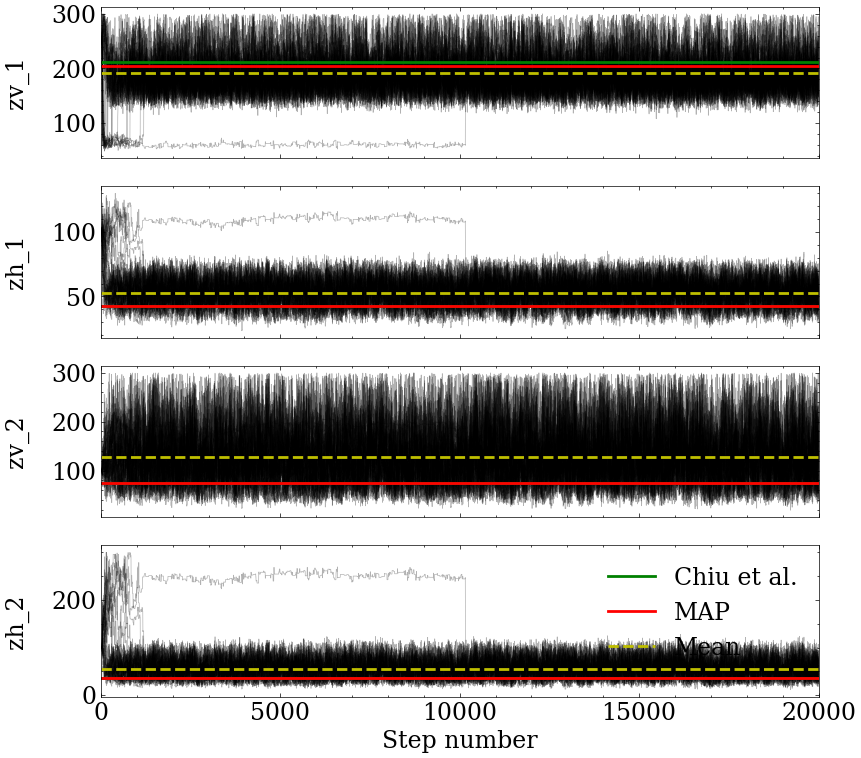

In [30]:
import matplotlib.pyplot as plt
import scienceplots

%matplotlib inline

# Set the style to 'science'
plt.style.use('science')

# Disable LaTeX rendering
plt.rcParams['text.usetex'] = False

# Assuming sampler is your emcee.EnsembleSampler object
samples_whole = sampler.get_chain()

# Plot the traces of the parameters
fig_samples_all, axes = plt.subplots(ndim, figsize=(9, 8), sharex=True)
labels = symbols_list

fs = 17
# Set font properties with all sizes set to 25
plt.rcParams.update({
    'font.family': 'serif', 
    'font.serif': 'DejaVu Serif',  # Or 'Times New Roman' if installed
    'font.size': fs,                 # General font size
    'axes.titlesize': fs,           # Title size
    'axes.labelsize': fs,           # Axis label size
    'xtick.labelsize': fs,          # X-axis tick label size
    'ytick.labelsize': fs,          # Y-axis tick label size
    'legend.fontsize': fs            # Legend font size
})

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_whole[:, :, i], "k", alpha=0.3, linewidth=0.5)
    ax.set_xlim(0, len(samples_whole))  
    ax.set_ylabel(labels[i], fontsize=fs)
    ax.yaxis.set_label_coords(-0.1, 0.5)

    # Add horizontal lines for actual values, MAP, and mean
    ax.axhline(y=actual_values[i], color='g', linestyle='-', linewidth=2, label='Chiu et al.')
    ax.axhline(y=map_estimate[i], color='r', linestyle='-', linewidth=2, label='MAP')
    ax.axhline(y=mean_values[i], color='y', linestyle='--', linewidth=2, label='Mean')

    # Increase tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=fs)

    # Reduce the number of x-ticks
    xticks = ax.get_xticks()
    reduced_xticks = xticks[::len(xticks) // 4]  # Adjust this for desired number of ticks
    ax.set_xticks(reduced_xticks)

# Set xlabel for the last subplot
axes[-1].set_xlabel("Step number", fontsize=fs)
plt.legend(loc='upper right', fontsize=fs)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


### Corner plot visualization

In [95]:
emcee.autocorr.integrated_time(samples, c=5, tol=50, quiet=False, has_walkers=True)

array([1.00412594])

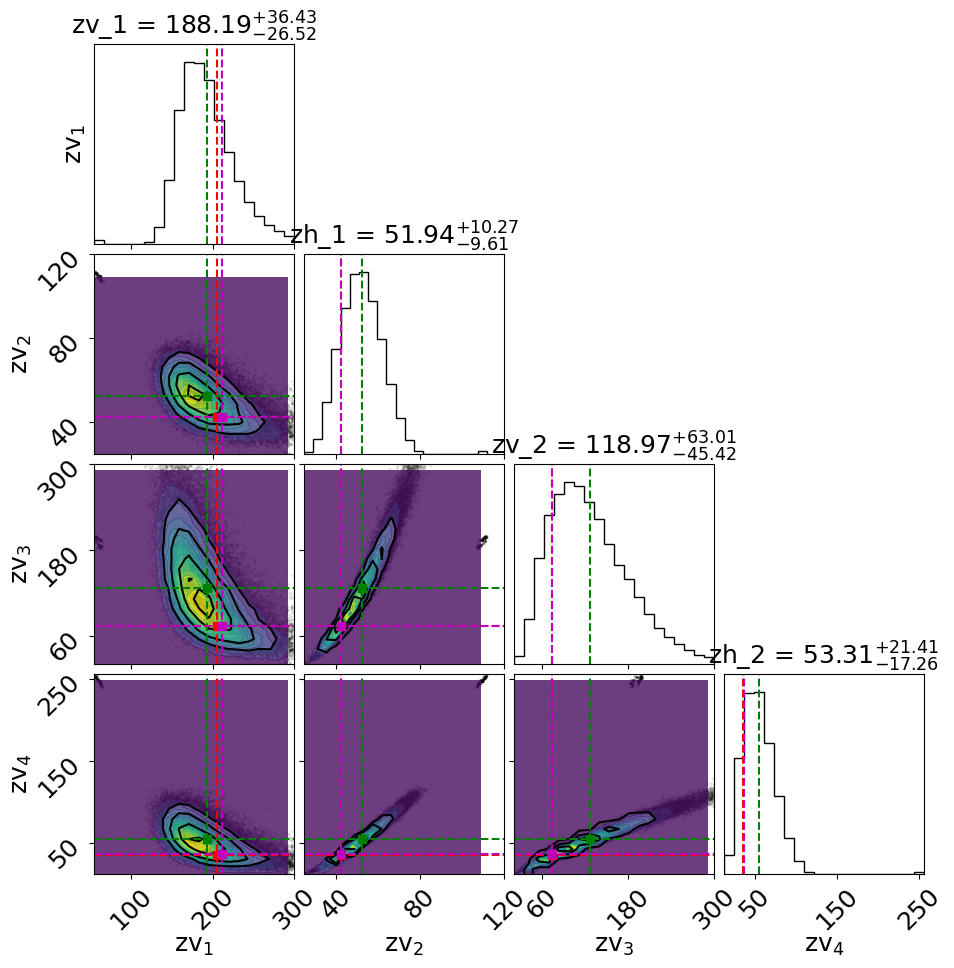

In [31]:
import matplotlib.pyplot as plt
import corner
import numpy as np

%matplotlib inline

plt.style.use('default')

# Set the font size
fs = 18
plt.rcParams.update({
    'font.size': fs,                # General font size
    'axes.titlesize': fs,          # Title size
    'axes.labelsize': fs,          # Axis label size
    'xtick.labelsize': fs,         # X-axis tick label size
    'ytick.labelsize': fs,         # Y-axis tick label size
    'legend.fontsize': fs,         # Legend font size
    'font.serif': ['DejaVu Serif'] # Specify serif font
})

# Create the corner plot
figure_corner = corner.corner(samples, labels=symbols_list, show_titles=True, title_fmt=".2f", title_kwargs={"fontsize": fs})

# Access the axes in the corner plot
axes = figure_corner.axes

# Set tick frequency
tick_frequency = 2  # Adjust this value to change the frequency

# Loop over the axes to set tick frequency and format labels
for i, ax in enumerate(axes):
    # Get current ticks
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()

    # Set new ticks with reduced frequency
    ax.set_xticks(xticks[::tick_frequency])  # Reduce x ticks
    ax.set_yticks(yticks[::tick_frequency])  # Reduce y ticks

    # Format x-axis label with subscript
    if i % ndim == 0:  # Only for the first column
        ax.set_ylabel(f"$\\mathrm{{zv}}_{{{i // ndim + 1}}}$", fontsize=fs)  # Adjust indexing if necessary

    # Format y-axis label with subscript
    if i >= ndim * (ndim - 1):  # Only for the last row
        ax.set_xlabel(f"$\\mathrm{{zv}}_{{{i % ndim + 1}}}$", fontsize=fs)  # Adjust indexing if necessary

# Loop over the diagonal to add mean and MAP lines
for i in range(ndim):
    ax = axes[i * ndim + i]
    ax.axvline(mean_values[i], color="g", linestyle="--", label="Mean")
    ax.axvline(map_estimate[i], color="r", linestyle="--", label="MAP Estimate")
    ax.axvline(actual_values[i], color='m', linestyle='--', label='Chiu et al.')

# Loop over the scatter plots (off-diagonal) to create filled contours
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi * ndim + xi]

        # Create filled contours using histogram2d
        hist, xedges, yedges = np.histogram2d(samples[:, xi], samples[:, yi], bins=30)
        X, Y = np.meshgrid(xedges[:-1], yedges[:-1])

        # Use contourf for filled contours
        ax.contourf(X, Y, hist.T, levels=15, cmap='viridis', alpha=0.8)  # Transpose hist for correct orientation

        # Add vertical and horizontal lines at the mean and MAP estimate
        ax.axvline(mean_values[xi], color="g", linestyle="--")
        ax.axvline(map_estimate[xi], color="r", linestyle="--")
        ax.axvline(actual_values[xi], color='m', linestyle='--')
        ax.axhline(mean_values[yi], color="g", linestyle="--")
        ax.axhline(map_estimate[yi], color="r", linestyle="--")
        ax.axhline(actual_values[yi], color='m', linestyle='--')

        # Plot points for mean and MAP estimate
        ax.plot(mean_values[xi], mean_values[yi], "sg")
        ax.plot(map_estimate[xi], map_estimate[yi], "sr")
        ax.plot(actual_values[xi], actual_values[yi], "sm")

# Optionally save the figure
# figure_corner.savefig(image_path_figure_corner, bbox_inches='tight', dpi=300)
plt.show()


### S Plotter

Center: 25.00 GHz
Normal: 16.7 GHz - 33.3 GHz, BW: 16.6 GHz (0.664)
Diff: S21 - S31 (0.665) offset 1.64 dB


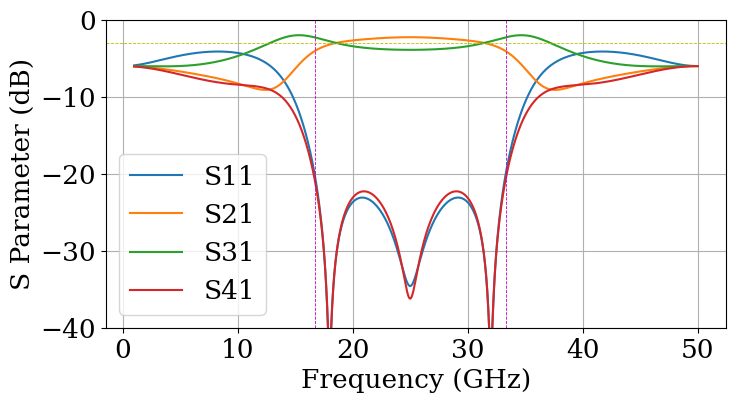

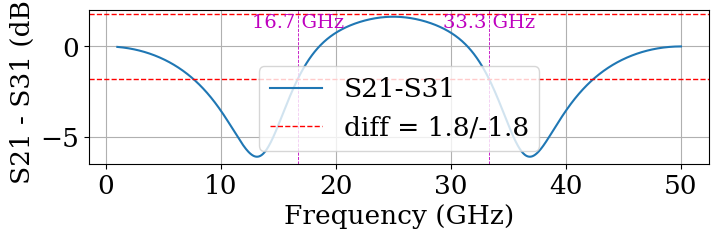

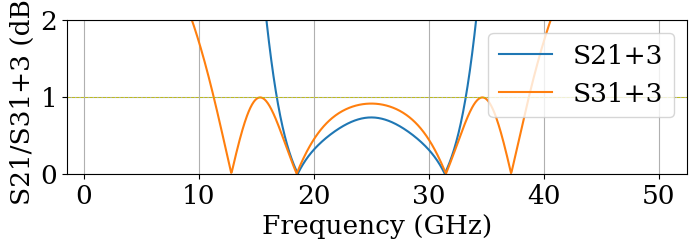

In [72]:
%matplotlib inline
plt.style.use('default')

# Set the font size
fs = 19
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': fs,                # General font size
    'axes.titlesize': fs,          # Title size
    'axes.labelsize': fs,          # Axis label size
    'xtick.labelsize': fs,         # X-axis tick label size
    'ytick.labelsize': fs,         # Y-axis tick label size
    'legend.fontsize': fs           # Legend font size
})

# Create the MCMC plot using your function
figure_mcmc_splot, test = qhdc_creater_plotter([181.2879916, 41.90164529, 87.04442775, 36.43901694])

Center: 25.00 GHz
Normal: 16.7 GHz - 33.2 GHz, BW: 16.5 GHz (0.66)
Diff: S21 - S31 (0.647) offset 1.45 dB
140.75112342834473


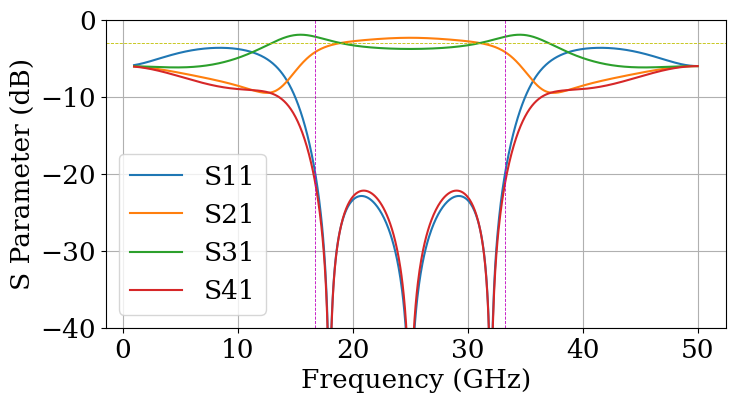

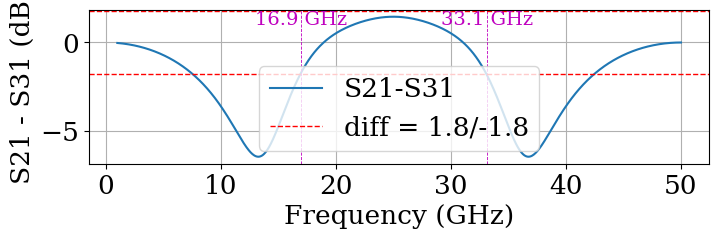

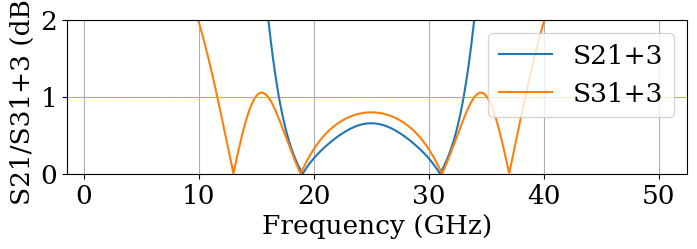

In [35]:
%matplotlib inline
plt.style.use('default')

# Set the font size
fs = 19
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': fs,                # General font size
    'axes.titlesize': fs,          # Title size
    'axes.labelsize': fs,          # Axis label size
    'xtick.labelsize': fs,         # X-axis tick label size
    'ytick.labelsize': fs,         # Y-axis tick label size
    'legend.fontsize': fs           # Legend font size
})

start = time.time() 
figure_lit_splot = qhdc_creater_plotter([182.9,39.6,75.9,33.1])
end = time.time() 
print((end - start)*1000)

In [50]:
%matplotlib qt
plt.style.use('default')

# Set the font size
fs = 19
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': fs,                # General font size
    'axes.titlesize': fs,          # Title size
    'axes.labelsize': fs,          # Axis label size
    'xtick.labelsize': fs,         # X-axis tick label size
    'ytick.labelsize': fs,         # Y-axis tick label size
    'legend.fontsize': fs           # Legend font size
})

# Create the MCMC plot using your function
figure_mcmc_splot, test = qhdc_creater_plotter([204.77, 38.63, 56.36, 30.09])

Center: 25.00 GHz
Normal: 18.3 GHz - 31.8 GHz, BW: 13.5 GHz (0.54)
Diff: S21 - S31 (0.467) offset 0.0 dB


#### Impedance tweaker

In [45]:
mean_values = [183.8637649,   42.17068935,  90.33837863,  37.11888914]

In [47]:
%matplotlib qt
from matplotlib.widgets import Slider, Button

def qhdc_eq_fetch(derived_imp):
    #input
    eps_r = 4.0
    f_res = 25 * pow(10, 9)  #GHz
    z_0 = 50
    z_line = z_0/math.sqrt(2)
    pi = math.pi
    
    s11_plot_dB_pre = []
    s21_plot_dB_pre = []
    s31_plot_dB_pre = []
    s41_plot_dB_pre = []

    for f_test in freq_Hz:
        s11_plot_dB_pre.append(get_s11eq(*np.append([f_test, 50], derived_imp)))
        s21_plot_dB_pre.append(get_s21eq(*np.append([f_test, 50], derived_imp)))
        s31_plot_dB_pre.append(get_s31eq(*np.append([f_test, 50], derived_imp)))
        s41_plot_dB_pre.append(get_s41eq(*np.append([f_test, 50], derived_imp)))

    s11_plot_dB = 20 * np.log10(np.abs(s11_plot_dB_pre))
    s21_plot_dB = 20 * np.log10(np.abs(s21_plot_dB_pre))
    s31_plot_dB = 20 * np.log10(np.abs(s31_plot_dB_pre))
    s41_plot_dB = 20 * np.log10(np.abs(s41_plot_dB_pre))
 
    return [s11_plot_dB, s21_plot_dB, s31_plot_dB, s41_plot_dB]
 
freq_Hz = np.linspace(1 * pow(10, 9), 50 * pow(10, 9), 1000)
# Convert frequency values from Hz to GHz
freq_GHz = freq_Hz / pow(10, 9)

# Get output
s11_variable, s21_variable, s31_variable, s41_variable = qhdc_eq_fetch(list(mean_values))
# Calculate the difference
s21_minus_s31 = s21_variable - s31_variable

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# Plot the first four S-parameters
line_s11, = ax1.plot(freq_GHz, s11_variable, label='S11')
line_s21, = ax1.plot(freq_GHz, s21_variable, label='S21')
line_s31, = ax1.plot(freq_GHz, s31_variable, label='S31')
line_s41, = ax1.plot(freq_GHz, s41_variable, label='S41')
#ax1.set_xlabel('Frequency (GHz)')
ax1.set_ylabel('S Parameter (dB)')
ax1.grid(True)
ax1.legend()

# Plot the difference in the second subplot
line_diff, = ax2.plot(freq_GHz, s21_minus_s31, label='S21 - S31', linestyle='--', color='orange')
ax2.axhline(y=-1.8, color='red', linestyle='--')
ax2.axhline(y=1.8, color='red', linestyle='--')
ax2.set_xlabel('Frequency (GHz)')
ax2.set_ylabel('S21-S31 (dB)')
ax2.grid(True)
ax2.legend()


# Create slider axes
axis = plt.axes([0.75, 0.95, 0.14, 0.015])
axis2 = plt.axes([0.75, 0.85, 0.14, 0.015])
axis3 = plt.axes([0.75, 0.75, 0.14, 0.015])
axis4 = plt.axes([0.75, 0.65, 0.14, 0.015])

# Create sliders
slider1 = Slider(axis, 'First', mean_values[0] - 25, mean_values[0] + 25, valinit=mean_values[0])
slider2 = Slider(axis2, "Second", mean_values[1] - 25, mean_values[1] + 25, valinit=mean_values[1])
slider3 = Slider(axis3, "Third", mean_values[2] - 25, mean_values[2] + 25, valinit=mean_values[2])
slider4 = Slider(axis4, "Fourth", mean_values[3] - 25, mean_values[3] + 25, valinit=mean_values[3])

# Create button axes for arrows (adjusted position to avoid overlap)
button_ax1_up = plt.axes([0.85, 0.95, 0.025, 0.02])
button_ax1_down = plt.axes([0.75, 0.95, 0.025, 0.02])
button_ax2_up = plt.axes([0.85, 0.85, 0.025, 0.02])
button_ax2_down = plt.axes([0.75, 0.85, 0.025, 0.02])
button_ax3_up = plt.axes([0.85, 0.75, 0.025, 0.02])
button_ax3_down = plt.axes([0.75, 0.75, 0.025, 0.02])
button_ax4_up = plt.axes([0.85, 0.65, 0.025, 0.02])
button_ax4_down = plt.axes([0.75, 0.65, 0.025, 0.02])

# Create buttons
button1_up = Button(button_ax1_up, '^', color='lightgoldenrodyellow')
button1_down = Button(button_ax1_down, 'v', color='lightgoldenrodyellow')
button2_up = Button(button_ax2_up, '^', color='lightgoldenrodyellow')
button2_down = Button(button_ax2_down, 'v', color='lightgoldenrodyellow')
button3_up = Button(button_ax3_up, '^', color='lightgoldenrodyellow')
button3_down = Button(button_ax3_down, 'v', color='lightgoldenrodyellow')
button4_up = Button(button_ax4_up, '^', color='lightgoldenrodyellow')
button4_down = Button(button_ax4_down, 'v', color='lightgoldenrodyellow')


# Initialize a list to keep track of the frequency label text objects
label_texts = []

def update(val):
    # Clear previous labels
    for label in label_texts:
        label.remove()
    label_texts.clear()  # Clear the list

    new_mean_values = [
        slider1.val,
        slider2.val,
        slider3.val,
        slider4.val
    ]
    
    # Get updated output based on new mean values
    s11_variable, s21_variable, s31_variable, s41_variable = qhdc_eq_fetch(new_mean_values)
    
    # Update the plot lines for S-parameters
    line_s11.set_ydata(s11_variable)
    line_s21.set_ydata(s21_variable)
    line_s31.set_ydata(s31_variable)
    line_s41.set_ydata(s41_variable)
    
    # Calculate the difference and update the second plot
    s21_minus_s31 = s21_variable - s31_variable
    line_diff.set_ydata(s21_minus_s31)
    peak_index = np.argmax(s21_minus_s31)

    # Find the crossing indices again
    crossing_indices = []
    for i in range(1, len(s21_minus_s31)):
        if (s21_minus_s31[i - 1] < -1.8 <= s21_minus_s31[i]) or (s21_minus_s31[i - 1] >= -1.8 > s21_minus_s31[i]):
            crossing_indices.append(i)

    exact_crossing_indices = [i for i, value in enumerate(s21_minus_s31) if value == -1.8]
    crossing_indices.extend(exact_crossing_indices)
    crossing_indices = sorted(set(crossing_indices))  # Remove duplicates and sort

    # Plot vertical lines and labels at crossing points
    for index in crossing_indices:
        #ax2.axvline(x=freq_GHz[index], color='m', linestyle='--', linewidth=0.6)
        label = ax2.text(freq_GHz[index], 0.8, f'{freq_GHz[index]:.1f} GHz', color='m', fontsize=14, ha='center', va='bottom')
        label_texts.append(label)  # Keep track of the label

    # Calculate frequency differences if there are enough crossing points
    temp_freq_list = sorted([freq_GHz[i] for i in crossing_indices])
    if len(temp_freq_list) > 2:
        diff_bw_s21_s31 = round((temp_freq_list[2] - temp_freq_list[1]) / (f_res / 1e9), 3)
        ax2.set_title(f'Diff: S21 - S31 ({diff_bw_s21_s31}) offset {round(s21_minus_s31[peak_index], 2)} dB')

    # Redraw the figures
    fig.canvas.draw_idle()

# Attach the update function to the sliders
slider1.on_changed(update)
slider2.on_changed(update)
slider3.on_changed(update)
slider4.on_changed(update)

# Button functions for sliders
def adjust_slider(slider, delta):
    slider.set_val(slider.val + delta)
    update(None)

least_count = 0.2
button1_up.on_clicked(lambda event: adjust_slider(slider1, least_count))
button1_down.on_clicked(lambda event: adjust_slider(slider1, -least_count))
button2_up.on_clicked(lambda event: adjust_slider(slider2, least_count))
button2_down.on_clicked(lambda event: adjust_slider(slider2, -least_count))
button3_up.on_clicked(lambda event: adjust_slider(slider3, least_count))
button3_down.on_clicked(lambda event: adjust_slider(slider3, -least_count))
button4_up.on_clicked(lambda event: adjust_slider(slider4, least_count))
button4_down.on_clicked(lambda event: adjust_slider(slider4, -least_count))

# Create button axes for the reset button
reset_button_ax = plt.axes([0.05, 0.05, 0.14, 0.05])  # Adjust position as needed
reset_button = Button(reset_button_ax, 'Reset', color='lightgoldenrodyellow')

# Define the reset function
def reset(event):
    slider1.set_val(mean_values[0])
    slider2.set_val(mean_values[1])
    slider3.set_val(mean_values[2])
    slider4.set_val(mean_values[3])
    update(None)  # Call update to refresh the plot with the reset values

# Connect the reset button to the reset function
reset_button.on_clicked(reset)

plt.show()

## MCMC Convegence tests and statistical analysis

### Bayesian Inference Analysis

In [41]:
idata1 = az.from_emcee(sampler, var_names=symbols_list)
idata1.sel(draw=slice(burn_in, None))

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

### Mean and HPD of stationary post distribution

array([<Axes: title={'center': 'zv_1'}>, <Axes: title={'center': 'zh_1'}>,
       <Axes: title={'center': 'zv_2'}>, <Axes: title={'center': 'zh_2'}>],
      dtype=object)

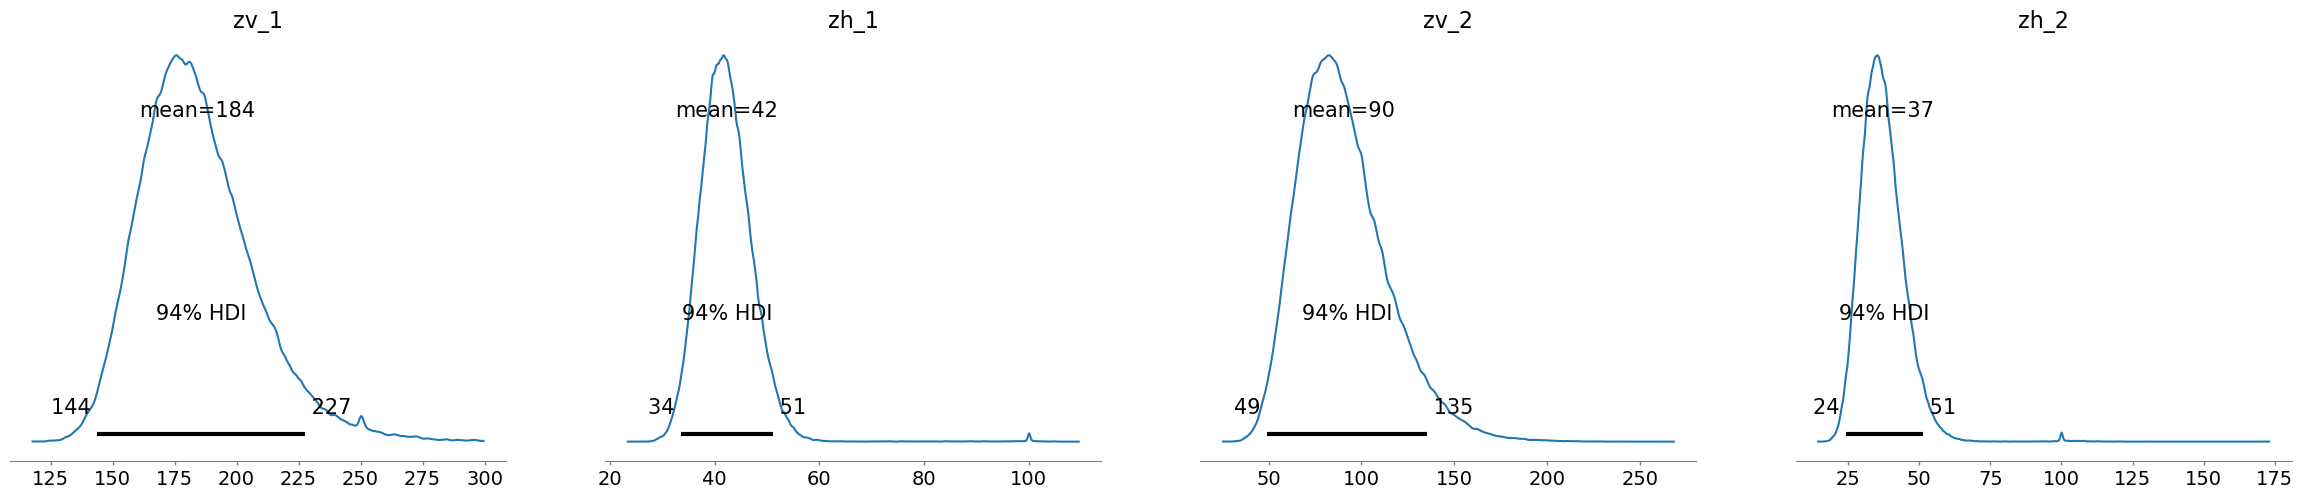

In [42]:
%matplotlib inline

plt.style.use('default')
az.plot_posterior(idata1, var_names=symbols_list)

In [43]:
summary = az.summary(idata1)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
zv_1,184.192,23.045,143.902,227.426,0.237,0.169,10020.0,17076.0,1.0
zh_1,42.302,5.472,33.598,51.215,0.057,0.040,9280.0,24851.0,1.0
zv_2,90.315,24.054,49.051,135.474,0.253,0.179,9072.0,22000.0,1.0
zh_2,37.326,8.144,24.295,51.211,0.085,0.060,9261.0,22611.0,1.0


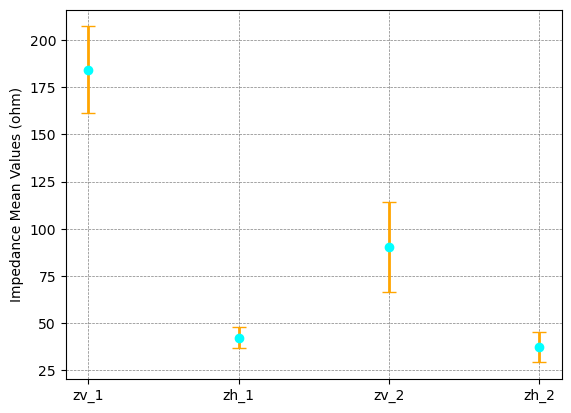

In [44]:
%matplotlib inline

symbols_str = [str(symbol) for symbol in symbols_list]

# Create the plot
fig, ax = plt.subplots()

# Error bar plot with customized aesthetics
ax.errorbar(symbols_str, 
             np.array(list(summary['mean'])),
             yerr=np.array(list(summary['sd'])), 
             fmt='o', 
             color='cyan',  # Marker color
             ecolor='orange',  # Error bar color
             elinewidth=2,  # Thickness of error bars
             capsize=5)  # Size of error bar caps

ax.set_ylabel('Impedance Mean Values (ohm)')
#ax.set_title('Result of run with one sigma variation')

# Customize the grid
ax.grid(color='gray', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()

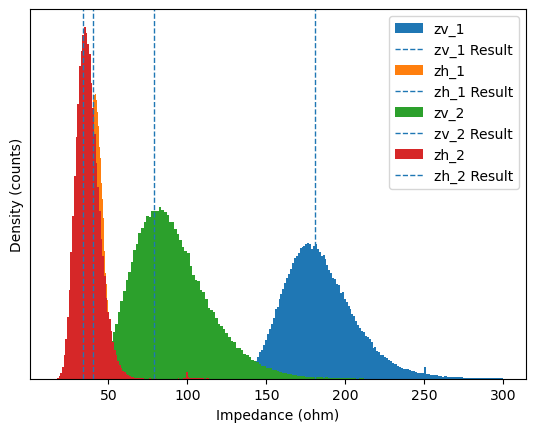

In [45]:
%matplotlib inline

for i in range(4):
    chain = sampler.get_chain()[:, :, i].T

    plt.hist(chain.flatten(), bins=150, label = str(symbols_list[i]))
    plt.gca().set_yticks([])
    plt.axvline(x = map_estimate[i],linestyle='--', linewidth=1, label = f'{symbols_list[i]} Result')
    plt.xlabel("Impedance (ohm)")
    plt.ylabel(f"Density (counts)");
    #plt.title('Marginalized density in all dimensions')
    #plt.xlim(170,180)
    plt.legend()

### Autocorrelation time estimates

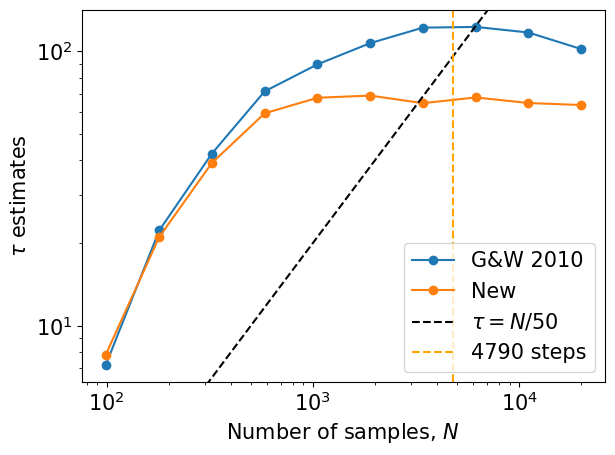

In [46]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    if norm:
        acf /= acf[0]

    return acf

def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

# ===========================================

plt.style.use('default')
fs = 15  # Font size
plt.rcParams.update({
    'font.size': fs,
    'axes.titlesize': fs,
    'axes.labelsize': fs,
    'xtick.labelsize': fs,
    'ytick.labelsize': fs,
    'legend.fontsize': fs
})

chain = sampler.get_chain()[:, :, 0].T

N = np.exp(np.linspace(np.log(100), np.log(chain.shape[1]), 10)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
for i, n in enumerate(N):
    gw2010[i] = autocorr_gw2010(chain[:, :n])
    new[i] = autocorr_new(chain[:, :n])

plt.loglog(N, gw2010, "o-", label="G&W 2010")
plt.loglog(N, new, "o-", label="New")
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.ylim(ylim)
plt.xlabel("Number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=fs)

# Finding the intersection between G&W 2010 and the reference line
difference = gw2010 - (N / 50.0)
indices = np.where(np.diff(np.sign(difference)))[0]

if len(indices) > 0:
    idx = indices[0]  # Take the first intersection
    n_intersect = (N[idx] + N[idx + 1]) / 2  # Average the N values around the intersection
    plt.axvline(n_intersect, color='orange', linestyle='--', label=f'{n_intersect:.0f} steps')

#plt.title('Autocorrelation Time Estimates', fontsize=fs)
plt.legend(fontsize=fs)
plt.tight_layout()  # Adjust layout to make it cleaner
plt.show()


## Run info

#### Run parameters

In [50]:
print('guess: ' + str(guess))
print('y: ' + str(y))
print('yerr: ' + str(y_err_tol_matrix))
print('freq_solve: ' + str(freq_solve))
print('ndim: ' + str(ndim))
print('nwalkers: ' + str(nwalkers))
print('nsteps: ' + str(nsteps))
print('pert: ' + str(pert))

guess: [250, 100, 100, 100]
y: [[0.00141421 0.00141421 0.00141421]
 [0.707      0.707      0.707     ]
 [0.707      0.707      0.707     ]
 [0.00141421 0.00141421 0.00141421]
 [0.1        0.1        0.1       ]]
yerr: [[0.1 0.1 0.1]
 [0.1 0.1 0.1]
 [0.1 0.1 0.1]
 [0.1 0.1 0.1]
 [0.1 0.1 0.1]]
freq_solve: [18000000000.0, 25000000000.0, 32000000000.0]
ndim: 4
nwalkers: 30
nsteps: 20000
pert: 0.001


#### Results

In [350]:
print('map_estimate: ' + str(np.round((map_estimate), 4)))
print('Actual Value: ' + str(np.round(actual_values, 4)))

print('\n')
print("Mean values:", mean_values)
print("Median values:", median_values)   
print("Standard deviations:", std_devs)

map_estimate: [208.4309  40.9508  82.9444  34.9549]
Actual Value: [211.7   42.7   74.8   36.65]


Mean values: [208.43092841  40.9508038   82.94438219  34.95490425]
Median values: [208.43092847  40.95080378  82.94438204  34.95490424]
Standard deviations: [1.99371492e-06 1.95382850e-07 1.07226480e-06 3.06900172e-07]


# Save samples

In [654]:
# Assuming `samples` is your array of samples
samples = sampler.get_chain(discard=0, thin=1)
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# Save the samples to a file
np.save(f"npy_logs/del_run{now}_thin{thin}_discard{burn_in}_{len(freq_solve)}_w{nwalkers}_s{nsteps}.npy", samples)

# Read saved files

In [655]:
samples_read = np.load(f"npy_logs/del_run{now}_thin{thin}_discard{burn_in}_{len(freq_solve)}_w{nwalkers}_s{nsteps}.npy")

samples_after_burn_in = samples_read[burn_in:]
samples_thinned = samples_after_burn_in[::thin]
# Reshape the array to (n_samples, n_walkers * n_dim)
n_samples, n_walkers, n_dim = samples_thinned.shape
samples_flat = samples_thinned.reshape(n_samples * n_walkers, n_dim)

In [656]:
# Calculate the mean of the postemean_values distributions
mean_values = np.mean(samples_flat, axis=0)
print("Mean values:", mean_values)

# Calculate the median of the posterior distributions
median_values = np.median(samples_flat, axis=0)
print("Median values:", median_values)

# Calculate the standard deviation of the posterior distributions
std_devs = np.std(samples_flat, axis=0)
print("Standard deviations:", std_devs)

Mean values: [182.92023258  39.57044797  75.90594349  33.10291462]
Median values: [182.92016979  39.57038262  75.90560403  33.10280306]
Standard deviations: [0.08099887 0.00969186 0.05556544 0.01605135]


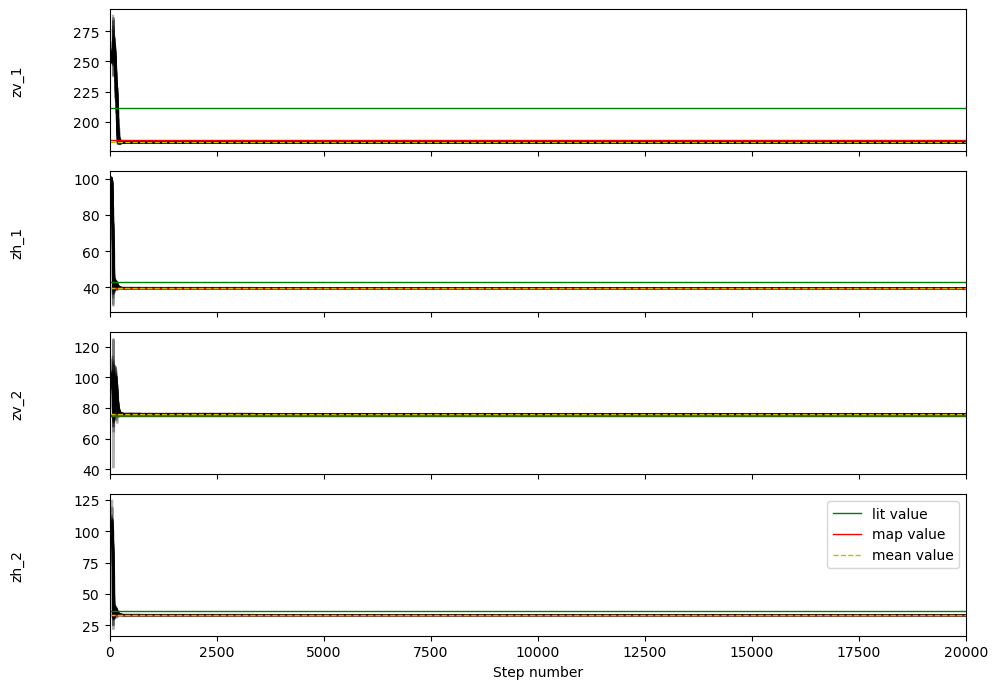

In [673]:
plt.style.use('default')
fig_samples_all, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = symbols_list

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_read))  
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.axhline(y=actual_values[i], color='g', linestyle='-', linewidth=1, label = 'lit value')
    ax.axhline(y=map_estimate[i], color='r', linestyle='-', linewidth=1, label = 'map value')
    ax.axhline(y=mean_values[i], color='y', linestyle='--', linewidth=1, label = 'mean value')

plt.legend(loc = 'upper right')

axes[-1].set_xlabel("Step number")
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

# Define the image path in the current directory
image_path_fig_samples_all = os.path.join(os.getcwd(), "fig_samples_all.pdf")
fig_samples_all.savefig(image_path_fig_samples_all, bbox_inches='tight', dpi=300)


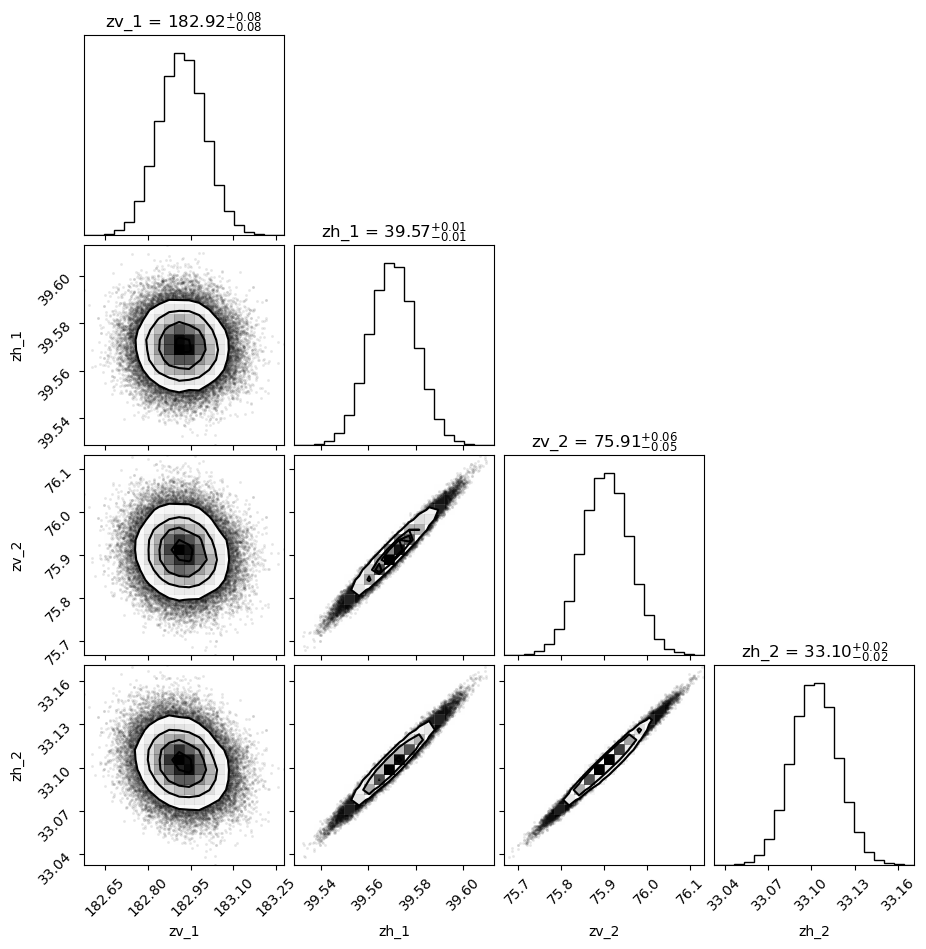

In [674]:
plt.style.use('default')
figure_corner = corner.corner(samples_flat, labels=symbols_list, show_titles=True, title_fmt=".2f", title_kwargs={"fontsize": 12})

# Define the image path in the current directory
image_path_figure_corner = os.path.join(os.getcwd(), "figure_corner.pdf")
figure_corner.savefig(image_path_figure_corner, bbox_inches='tight', dpi=300)

#### MCMC Impedance S plot

Center: 25.00 GHz
Center: 25.00 GHz


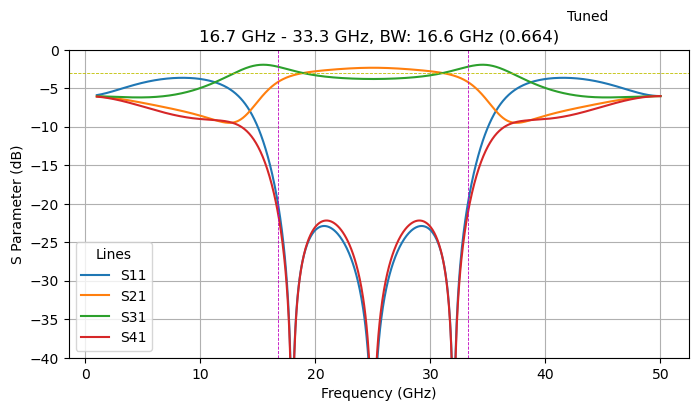

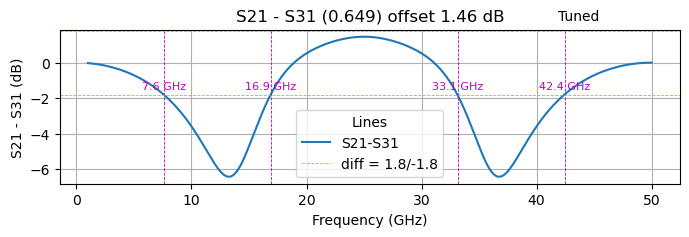

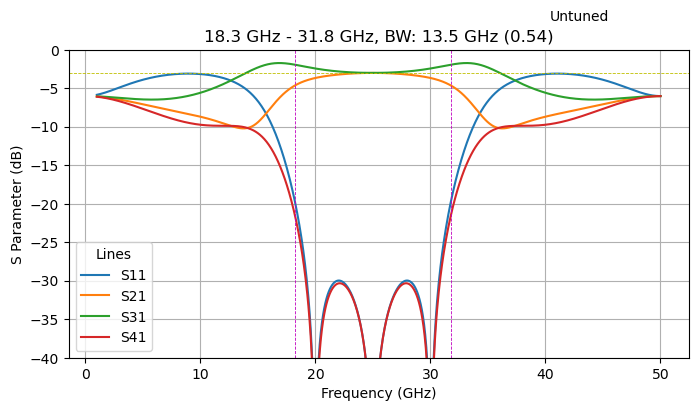

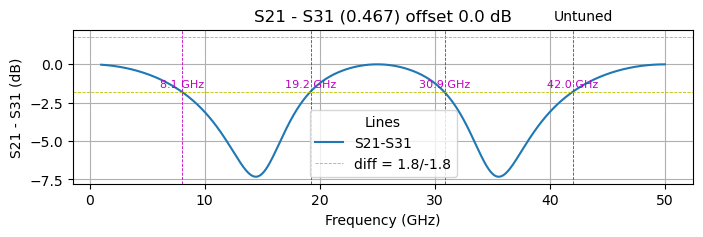

In [675]:
figure_mcmc_splot, figure_mcmc_bw_finder = qhdc_creater_plotter(list(mean_values))
figure_mcmc_splot_untune, figure_mcmc_bw_finder_untune = qhdc_creater_plotter([204.77, 38.63, 56.36, 30.09])

figure_mcmc_splot.suptitle('Tuned', fontsize=10, x=0.8, ha='right')
figure_mcmc_bw_finder.suptitle('Tuned', fontsize=10, x=0.8, ha='right')
figure_mcmc_splot_untune.suptitle('Untuned', fontsize=10, x=0.8, ha='right')
figure_mcmc_bw_finder_untune.suptitle('Untuned', fontsize=10, x=0.8, ha='right')

# Define the image path in the current directory
current_directory = os.getcwd()
image_path_figure_mcmc_splot = os.path.join(current_directory, "figure_mcmc_splot.pdf")
figure_mcmc_splot.savefig(image_path_figure_mcmc_splot, bbox_inches='tight', dpi=300)

image_path_figure_bw_finder = os.path.join(current_directory, "figure_mcmc_bw_finder.pdf")
figure_mcmc_bw_finder.savefig(image_path_figure_bw_finder, bbox_inches='tight', dpi=300)

image_path_figure_mcmc_splot_untune = os.path.join(current_directory, "figure_mcmc_splot_untune.pdf")
figure_mcmc_splot_untune.savefig(image_path_figure_mcmc_splot_untune, bbox_inches='tight', dpi=300)

image_path_figure_bw_finder_untune = os.path.join(current_directory, "figure_mcmc_bw_finder_untune.pdf")
figure_mcmc_bw_finder_untune.savefig(image_path_figure_bw_finder_untune, bbox_inches='tight', dpi=300)

In [676]:
idata1 = az.from_emcee(sampler, var_names=symbols_list)
idata1.sel(draw=slice(burn_in, None))

summary = az.summary(idata1)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
zv_1,183.525,6.299,182.752,183.086,0.123,0.087,4223.0,763.0,1.01
zh_1,39.804,3.481,39.550,39.591,0.048,0.034,3675.0,896.0,1.01
zv_2,76.072,1.848,75.792,76.024,0.034,0.024,3709.0,885.0,1.01
zh_2,33.391,4.174,33.070,33.137,0.059,0.042,3768.0,870.0,1.01


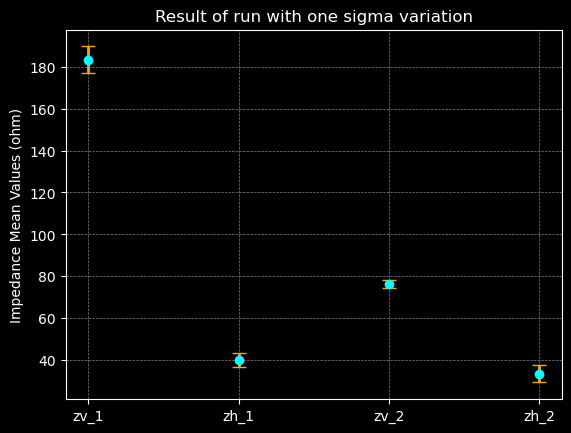

In [677]:
symbols_str = [str(symbol) for symbol in symbols_list]

plt.style.use('dark_background')
# Create the plot
fig, ax = plt.subplots()

# Error bar plot with customized aesthetics
ax.errorbar(symbols_str, 
             np.array(list(summary['mean'])),
             yerr=np.array(list(summary['sd'])), 
             fmt='o', 
             color='cyan',  # Marker color
             ecolor='orange',  # Error bar color
             elinewidth=2,  # Thickness of error bars
             capsize=5)  # Size of error bar caps

ax.set_ylabel('Impedance Mean Values (ohm)')
ax.set_title('Result of run with one sigma variation')

# Customize the grid
ax.grid(color='gray', linestyle='--', linewidth=0.5)

# Define the image path in the current directory
image_path_figure_dimensions_1sigmadeviation = os.path.join(os.getcwd(), "figure_1sigmadeviation.pdf")
plt.savefig(image_path_figure_dimensions_1sigmadeviation, bbox_inches='tight', dpi=300)

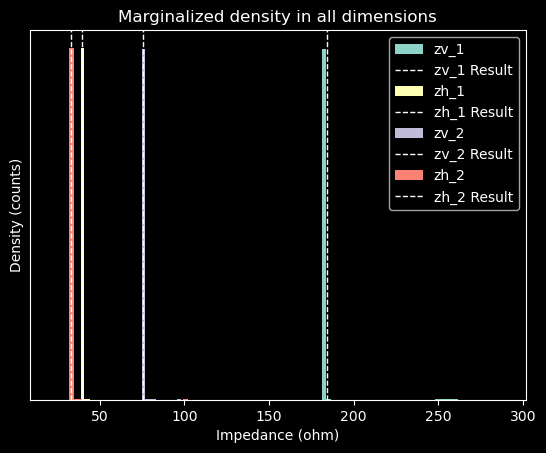

In [678]:
plt.style.use('dark_background')

for i in range(4):
    chain = sampler.get_chain()[:, :, i].T

    plt.hist(chain.flatten(), bins=40, label = str(symbols_list[i]))
    plt.gca().set_yticks([])
    plt.axvline(x = map_estimate[i],linestyle='--', linewidth=1, label = f'{symbols_list[i]} Result')
    plt.xlabel("Impedance (ohm)")
    plt.ylabel(f"Density (counts)");
    plt.title('Marginalized density in all dimensions')
    #plt.xlim(170,180)
    plt.legend()
    
# Define the image path in the current directory
image_path_figure_dimensions_density = os.path.join(os.getcwd(), "figure_density.pdf")
plt.savefig(image_path_figure_dimensions_density, bbox_inches='tight', dpi=300)

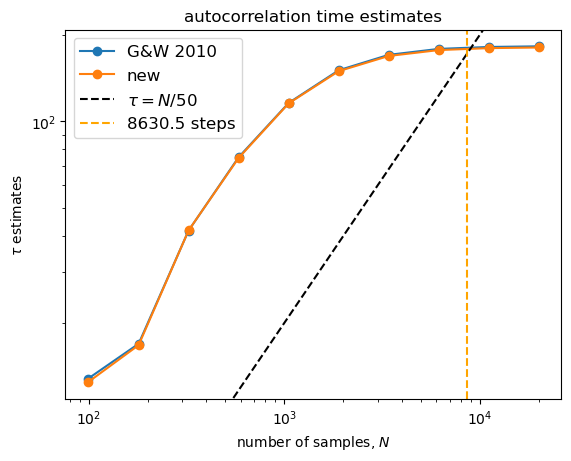

In [679]:
plt.style.use('default')
chain = sampler.get_chain()[:, :, 0].T

# Compute the estimators for a few different chain lengths
N = np.exp(np.linspace(np.log(100), np.log(chain.shape[1]), 10)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
for i, n in enumerate(N):
    gw2010[i] = autocorr_gw2010(chain[:, :n])
    new[i] = autocorr_new(chain[:, :n])

# Plot the comparisons
plt.loglog(N, gw2010, "o-", label="G&W 2010")
plt.loglog(N, new, "o-", label="new")
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14)

# Finding the intersection between G&W 2010 and the reference line
difference = gw2010 - (N / 50.0)
indices = np.where(np.diff(np.sign(difference)))[0]

if len(indices) > 0:
    # Interpolation to find a more precise intersection point
    idx = indices[0]  # Take the first intersection
    n_intersect = (N[idx] + N[idx + 1]) / 2  # Average the N values around the intersection
    plt.axvline(n_intersect, color='orange', linestyle='--', label=f'{n_intersect} steps')
plt.title('autocorrelation time estimates')
plt.legend(fontsize=12)

# Define the image path in the current directory
image_path_figure_autocorr_time = os.path.join(os.getcwd(), "figure_autocorr_time.pdf")
plt.savefig(image_path_figure_autocorr_time, bbox_inches='tight', dpi=300)

#### Generate report

In [680]:
# Helper function to convert arrays to vertical strings
def array_to_vertical_string(arr):
    return '\n'.join(map(str, arr))

# Helper function to convert lists to comma-separated strings
def list_to_string(lst):
    return ', '.join(f"{x:.1f}" for x in lst)

try:
    # Define the table data with formatted values
    data = [    
        ['Parameter', 'Value'],
        ['RUN PARAMETERS'],
        ['Guess given', str(guess)],
        ['Boundary values', array_to_vertical_string(y)],
        ['Boundary value error', array_to_vertical_string((y_err_tol_matrix))],
        ['Freq solve points (GHz)', str([int(round(x / 1000000000)) for x in freq_solve])],
        ['No. of variables', str(ndim)],
        ['No. of walkers', str(nwalkers)],
        ['No. of steps', str(nsteps)],
        ['Perturbation', str(pert)],
        ['Cores used', str(noofcores)],
        ['Correct Value', str(list_to_string(actual_values))],
        ['RESULTS OF RUN'],
        ['Burn in', str(burn_in)],
        ['Thin', str(thin)],
        ['Mean values', list_to_string(mean_values)],
        ['Median values', list_to_string(median_values)],
        ['Standard deviations', list_to_string(std_devs)],
        ['MAP Estimate', list_to_string(map_estimate)]
    ]
    
except:
    # Define the table data with formatted values
    data = [    
        ['Parameter', 'Value'],
        ['RUN PARAMETERS'],
        ['Guess given', str(guess)],
        ['Boundary values', array_to_vertical_string(y)],
        ['Boundary value error', array_to_vertical_string((y_err_tol_matrix))],
        ['Freq solve points (GHz)', str([int(round(x / 1000000000)) for x in freq_solve])],
        ['No. of variables', str(ndim)],
        ['No. of walkers', str(nwalkers)],
        ['No. of steps', str(nsteps)],
        ['Perturbation', str(pert)],
        ['Cores used', str(noofcores)],
        ['Correct Value', str(list_to_string(actual_values))], #list_to_string(actual_values)
        ['RESULTS OF RUN'],
        ['Burn in', str(burn_in)],
        ['Thin', str(thin)],
        ['Mean values', list_to_string(mean_values)],
        ['Median values', list_to_string(median_values)],
        ['Standard deviations', list_to_string(std_devs)]
    ]

# Create the table and add styles
table = Table(data)
table.setStyle(TableStyle([
    ('BACKGROUND', (0, 0), (-1, 0), colors.grey),  # Header row
    ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
    ('ALIGN', (0, 0), (-1, 0), 'CENTER'),
    ('BACKGROUND', (0, 1), (-1, -1), colors.beige),  # Default cell background
    ('ALIGN', (0, 1), (-1, -1), 'LEFT'),
    ('VALIGN', (0, 1), (-1, -1), 'TOP'),
    ('GRID', (0, 0), (-1, -1), 1, colors.black),
    ('FONT', (0, 0), (-1, 0), 'Helvetica-Bold'),
    ('FONT', (0, 1), (-1, -1), 'Helvetica'),

    # Style for 'RUN PARAMETERS' section heading
    ('BACKGROUND', (0, 1), (1, 1), colors.lightblue),
    ('FONT', (0, 1), (1, 1), 'Helvetica-Bold'),
    ('ALIGN', (0, 1), (1, 1), 'CENTER'),

    # Style for 'RESULTS OF RUN' section heading
    ('BACKGROUND', (0, 12), (1, 12), colors.lightgreen),
    ('FONT', (0, 12), (1, 12), 'Helvetica-Bold'),
    ('ALIGN', (0, 12), (1, 12), 'CENTER'),
]))

# Create a PDF file with A4 page size
table_pdf_path = "test.pdf"

# Check if the file exists and delete it if it does
if os.path.exists(table_pdf_path):
    os.remove(table_pdf_path)
    print(f"{table_pdf_path} already existed and has been deleted.")
else:
    print(f"{table_pdf_path} does not exist, so it will be created.")
    

# Create the PDF document template for the table
doc = SimpleDocTemplate(table_pdf_path, pagesize=A4)
# Define the styles for the document
styles = getSampleStyleSheet()
heading_style = styles['Title']
paragraph_style = styles['Normal']

# Generate current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
heading = Paragraph(f"<b>Date and Time: {current_datetime}</b>", heading_style)

# Create a paragraph block text
user_paragraph_text = input("Enter the paragraph text for the document: ")
paragraph = Paragraph(user_paragraph_text, paragraph_style)
# Create a paragraph block with user input text
paragraph = Paragraph(user_paragraph_text, paragraph_style)

# Define styles for the document
elements = [Spacer(1, 0.5*inch), heading, Spacer(1, 0.5*inch), paragraph, Spacer(1, 0.5*inch), table]
# Add summary table
summary_data = [['Parameter', 'Mean', 'SD', 'r_hat', 'ess_bulk', 'ess_tail']]
for symbol in symbols_list:
    summary_data.append([symbol, summary['mean'][symbol], summary['sd'][symbol], summary['r_hat'][symbol], summary['ess_bulk'][symbol], summary['ess_tail'][symbol]])

summary_table = Table(summary_data)
summary_table.setStyle(TableStyle([
    ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
    ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
    ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
    ('GRID', (0, 0), (-1, -1), 1, colors.black),
]))
elements.append(PageBreak())
heading = Paragraph(f"<b>Run Result analysis</b>", heading_style)
elements.append(summary_table)

doc.build(elements)





#========================================================================================================================================
#adding the plots
# Define paths for images
image_paths = {
    "Parameter space exploration Plot": image_path_fig_samples_all,
    "Corner Plot": image_path_figure_corner,
    "MCMC S Plot": image_path_figure_mcmc_splot,
    "S31_S21 differential plot": image_path_figure_bw_finder,
    "Untuned MCMC S Plot": image_path_figure_mcmc_splot_untune,
    "Untuned S31_S21 differential plot": image_path_figure_bw_finder_untune,
    "Result of Run with one sigma variation": image_path_figure_dimensions_1sigmadeviation,
    "Marginalised density of dimensions": image_path_figure_dimensions_density,
    "Autocorrelation time estimates": image_path_figure_autocorr_time,
}

# Define the path for the final combined PDF
combined_pdf_path = f"{current_datetime}_w{nwalkers}_s{nsteps}_{len(freq_solve)}.pdf"

# Create a PDF merger object
pdf_merger = PyPDF2.PdfMerger()

# Add the table PDF to the merger
pdf_merger.append(table_pdf_path)

# Add the image PDFs to the merger
for title, image_path in image_paths.items():
    if os.path.exists(image_path):
        pdf_merger.append(image_path)
    else:
        print(f"{image_path} does not exist and will not be added to the combined PDF.")

# Write out the combined PDF
pdf_merger.write(combined_pdf_path)
pdf_merger.close()

print(f"Combined PDF created successfully at {combined_pdf_path}!")

# Clean up: remove the intermediate PDF files
if os.path.exists(table_pdf_path):
    os.remove(table_pdf_path)
    print(f"{table_pdf_path} has been deleted.")

for image_path in image_paths.values():
    if os.path.exists(image_path):
        os.remove(image_path)
        print(f"{image_path} has been deleted.")

test.pdf does not exist, so it will be created.


Enter the paragraph text for the document:  The three section run was improved from high constraint caused issues. Now it is performing to satisfaction.


Combined PDF created successfully at 2024-10-11_14-58-11_w30_s20000_3.pdf!
test.pdf has been deleted.
/home/saurabhs/arjun/python_numba_mcmc/final_codes/amp constraint only/fig_samples_all.pdf has been deleted.
/home/saurabhs/arjun/python_numba_mcmc/final_codes/amp constraint only/figure_corner.pdf has been deleted.
/home/saurabhs/arjun/python_numba_mcmc/final_codes/amp constraint only/figure_mcmc_splot.pdf has been deleted.
/home/saurabhs/arjun/python_numba_mcmc/final_codes/amp constraint only/figure_mcmc_bw_finder.pdf has been deleted.
/home/saurabhs/arjun/python_numba_mcmc/final_codes/amp constraint only/figure_mcmc_splot_untune.pdf has been deleted.
/home/saurabhs/arjun/python_numba_mcmc/final_codes/amp constraint only/figure_mcmc_bw_finder_untune.pdf has been deleted.
/home/saurabhs/arjun/python_numba_mcmc/final_codes/amp constraint only/figure_1sigmadeviation.pdf has been deleted.
/home/saurabhs/arjun/python_numba_mcmc/final_codes/amp constraint only/figure_density.pdf has been d

# Section comparisons

In [33]:
def qhdc_comparison_s11(derived_imp_list):
    fig1, ax1 = plt.subplots(figsize=(8, 4))
    for derived_imp in derived_imp_list:
        #input
        eps_r = 4.0
        f_res = 25 * pow(10, 9)  #GHz
        z_0 = 50
        z_line = z_0/math.sqrt(2)
        pi = math.pi

        # Define symbols and electrical length for stub and TL
        f = sp.symbols('f')

        # chooseodd  invert
        imp_list = [z_0] + derived_imp + derived_imp[::-1][1:] + [z_0]
        #print(imp_list)
        for i in range(0,len(imp_list)-1,2):

            #print(imp_list[i], imp_list[i+1], imp_list[i+2])
            if i == 0:
                abcd_even = unitcell(imp_list[i], imp_list[i+1], imp_list[i+2], False, False)
                abcd_odd = unitcell(imp_list[i], imp_list[i+1], imp_list[i+2], True, False)
            else:
                abcd_even = abcd_even * unitcell(imp_list[i], imp_list[i+1], imp_list[i+2], False, False)
                abcd_odd = abcd_odd * unitcell(imp_list[i], imp_list[i+1], imp_list[i+2], True, False)


        a_e = abcd_even.row(0)[0]
        b_e = abcd_even.row(0)[1]
        c_e = abcd_even.row(1)[0]
        d_e = abcd_even.row(1)[1]

        a_o = abcd_odd.row(0)[0]
        b_o = abcd_odd.row(0)[1]
        c_o = abcd_odd.row(1)[0]
        d_o = abcd_odd.row(1)[1]

        gamma_e = (a_e + (b_e/z_0) - (c_e*z_0) - d_e ) / (a_e + (b_e/z_0) + (c_e*z_0) + d_e)
        gamma_o = (a_o + (b_o/z_0) - (c_o*z_0) - d_o ) / (a_o + (b_o/z_0) + (c_o*z_0) + d_o)
        t_e = 2 / (a_e + (b_e/z_0) + (c_e*z_0) + d_e)
        t_o = 2 / (a_o + (b_o/z_0) + (c_o*z_0) + d_o)

        s11 = (gamma_e + gamma_o) / 2
        s21 = (t_e + t_o) / 2
        s31 = (t_e - t_o) / 2
        s41 = (gamma_e - gamma_o) / 2

        # plotting

        s11_f = sp.lambdify(f, s11, 'numpy')  
        s21_f = sp.lambdify(f, s21, 'numpy')  
        s31_f = sp.lambdify(f, s31, 'numpy')  
        s41_f = sp.lambdify(f, s41, 'numpy')  

        #plot ===============================================================================

        freq_Hz = np.linspace(1 * pow(10, 9), 50 * pow(10, 9), 1000)
        # Convert frequency values from Hz to GHz
        freq_GHz = freq_Hz / pow(10, 9)

        # Evaluate s11_f for the generated frequency values
        s11_plot_dB = 20 * np.log10(np.abs(s11_f(freq_Hz)))
        s21_plot_dB = 20 * np.log10(np.abs(s21_f(freq_Hz)))
        s31_plot_dB = 20 * np.log10(np.abs(s31_f(freq_Hz)))
        s41_plot_dB = 20 * np.log10(np.abs(s41_f(freq_Hz)))


        # Plot the function
        
        ax1.plot(freq_GHz, s11_plot_dB, label=f'{len(derived_imp)-1}')
        # ax1.plot(freq_GHz, s21_plot_dB, label='S21')
        # ax1.plot(freq_GHz, s31_plot_dB, label='S31')
        # ax1.plot(freq_GHz, s41_plot_dB, label='S41')

        ax1.set_xlabel('Frequency (GHz)')
        ax1.set_ylabel('S Parameter (dB)')
        #ax1.set_title('S Parameters Plot (dB)')
        ax1.grid(True)

        # Print the frequency values
        print(f"Center: {f_res / 1e9:.2f} GHz")

        # Find indices where the absolute difference between s11_plot_dB and -10 is minimum
        closest_to_minus_10_indices = np.argsort(np.abs(np.array(s11_plot_dB) + 20))[:2]

        # Ensure there are two occurrences
        if len(closest_to_minus_10_indices) == 2:
            index_1, index_2 = closest_to_minus_10_indices
            f_cut_1 = round(freq_GHz[index_1], 1)
            f_cut_2 = round(freq_GHz[index_2], 1)

            bw = round(np.abs(f_cut_2 - f_cut_1), 1)
            bw_frac = round(bw / (f_res / 1e9), 3)
            print(f'Normal: {f_cut_1} GHz - {f_cut_2} GHz, BW: {bw} GHz ({bw_frac})')
        else:
            print("There are not enough occurrences with values closest to -10.")

        ax1.axhline(y=-3, color='y', linestyle='--', linewidth=0.6)

        ax1.legend(loc="best")
        ax1.set_ylim(-40, 0)
        ax1.set_xlim(25, 40)       

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import math

def qhdc_comparison_s21s31diff(derived_imp_list):
    # Create figure and axis for S21-S31 difference
    fig, ax = plt.subplots(figsize=(7, 3))
    fs = 17
    for derived_imp in derived_imp_list:
        # Input parameters
        eps_r = 4.0
        f_res = 25 * 10**9  # GHz
        z_0 = 50
        z_line = z_0 / math.sqrt(2)

        # Define symbols and electrical length for stub and TL
        f = sp.symbols('f')

        # Construct impedance list
        imp_list = [z_0] + derived_imp + derived_imp[::-1][1:] + [z_0]

        # Calculate ABCD matrices for even and odd modes
        abcd_even, abcd_odd = None, None
        for i in range(0, len(imp_list) - 1, 2):
            if i == 0:
                abcd_even = unitcell(imp_list[i], imp_list[i + 1], imp_list[i + 2], False, False)
                abcd_odd = unitcell(imp_list[i], imp_list[i + 1], imp_list[i + 2], True, False)
            else:
                abcd_even *= unitcell(imp_list[i], imp_list[i + 1], imp_list[i + 2], False, False)
                abcd_odd *= unitcell(imp_list[i], imp_list[i + 1], imp_list[i + 2], True, False)

        # Extract ABCD parameters
        a_e, b_e, c_e, d_e = abcd_even.row(0)[0], abcd_even.row(0)[1], abcd_even.row(1)[0], abcd_even.row(1)[1]
        a_o, b_o, c_o, d_o = abcd_odd.row(0)[0], abcd_odd.row(0)[1], abcd_odd.row(1)[0], abcd_odd.row(1)[1]

        # Calculate reflection and transmission coefficients
        gamma_e = (a_e + (b_e / z_0) - (c_e * z_0) - d_e) / (a_e + (b_e / z_0) + (c_e * z_0) + d_e)
        gamma_o = (a_o + (b_o / z_0) - (c_o * z_0) - d_o) / (a_o + (b_o / z_0) + (c_o * z_0) + d_o)
        t_e = 2 / (a_e + (b_e / z_0) + (c_e * z_0) + d_e)
        t_o = 2 / (a_o + (b_o / z_0) + (c_o * z_0) + d_o)

        # Calculate S-parameters
        s21 = (t_e + t_o) / 2
        s31 = (t_e - t_o) / 2

        # Create lambdified functions for plotting
        s21_f = sp.lambdify(f, s21, 'numpy')  
        s31_f = sp.lambdify(f, s31, 'numpy')

        # Generate frequency range for plotting
        freq_Hz = np.linspace(1 * 10**9, 50 * 10**9, 1000)
        freq_GHz = freq_Hz / 10**9

        # Evaluate S-parameters
        s21_plot_dB = 20 * np.log10(np.abs(s21_f(freq_Hz)))
        s31_plot_dB = 20 * np.log10(np.abs(s31_f(freq_Hz)))

        # Calculate S21 - S31 difference
        s21_s31_diff_db = s21_plot_dB - s31_plot_dB

        # Plotting the difference
        ax.plot(freq_GHz, s21_s31_diff_db, label=f'{len(derived_imp) - 1}', linewidth=2)

    # Formatting the plot
    ax.axhline(y=-3, color='orange', linestyle='--', linewidth=1)
    ax.set_xlabel('Frequency (GHz)', fontsize=fs)
    ax.set_ylabel('S21 - S31 (dB)', fontsize=fs)
    ax.set_ylim(-5, 2.5)
    ax.set_xlim(1, 50)  # Adjusted x-axis limits
    ax.legend(loc="best", fontsize=fs, frameon=True)
    ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
    ax.tick_params(axis='both', which='major', labelsize=fs)

    # Show plot
    plt.tight_layout()
    plt.show()


In [37]:
n3 = [181.2879916,41.90164529,87.04442775,36.43901694]
n5 = [364.6722209,48.48742397,193.76891437,46.03729744,154.82433077,44.96829244]
n7 = [478, 41.4, 288, 31.1, 141.77, 22.57, 74.9, 19.8]
n9 = [902.7, 48.5, 850.2, 46.4, 505.4, 43.8, 410.0, 41.8, 390.8, 41.0]

n3_chiu = [211.7, 42.7, 74.8, 36.65] #three section coupler
n5_chiu = [407.1,  49.05, 206.2, 48.37, 165.1, 48.05] #five section coupler

Center: 25.00 GHz
Normal: 16.7 GHz - 33.3 GHz, BW: 16.6 GHz (0.664)
Center: 25.00 GHz
Normal: 36.2 GHz - 13.9 GHz, BW: 22.3 GHz (0.892)
Center: 25.00 GHz
Normal: 11.2 GHz - 38.8 GHz, BW: 27.6 GHz (1.104)


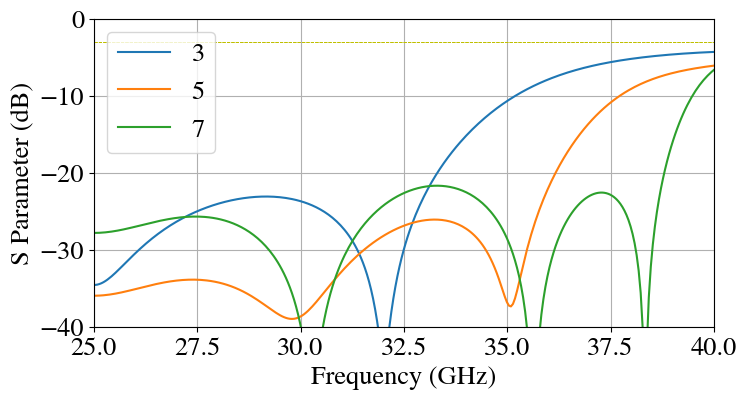

In [103]:
%matplotlib inline
qhdc_comparison_s11([n3,n5,n7])

In [49]:
fig.pdfstart = time.time() 
fig_9 = qhdc_creater_plotter_slow(n9)
end = time.time() 
print((end - start))

fig_9.savefig('fig9.pdf', dpi=300)

Center: 25.00 GHz
41.6 GHz - 8.4 GHz, BW: 33.2 GHz (1.328)
Diff: S21 - S31 (1.279) offset 7.26 dB
73786.589168787


AttributeError: 'tuple' object has no attribute 'savefig'

Center: 25.00 GHz


(<Figure size 800x400 with 1 Axes>, <Figure size 800x200 with 1 Axes>)

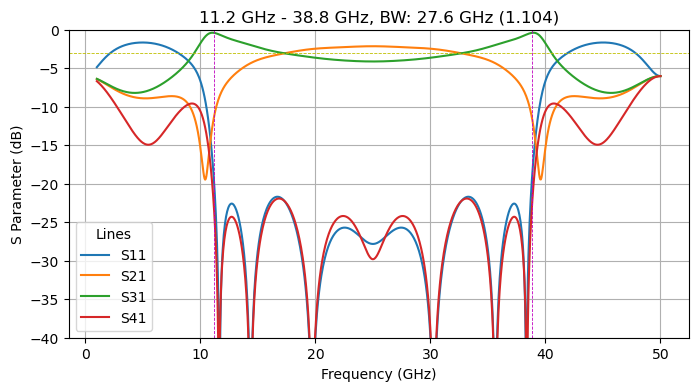

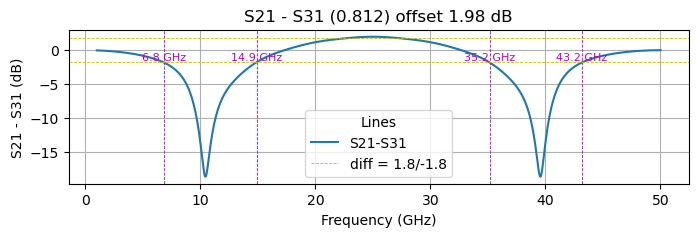

In [50]:
qhdc_creater_plotter_slow(n7)

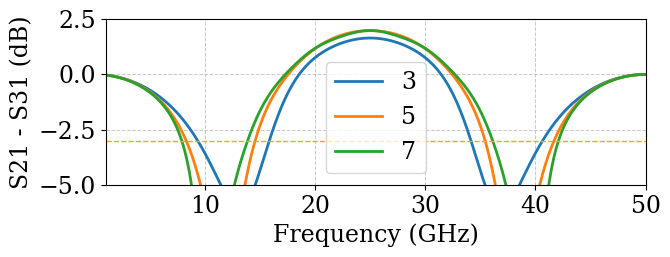

In [106]:
qhdc_comparison_s21s31diff([n3,n5,n7])

#### BW Comparison

In [48]:
(0.665/0.567), (0.769/0.797)

(1.1728395061728396, 0.9648682559598494)

In [49]:
(1.64/0.93), (1.97/2.37)

(1.7634408602150535, 0.8312236286919831)

In [79]:
bw = [0.665, 0.769, 0.812]
ripple = [1.64, 1.97, 1.98]

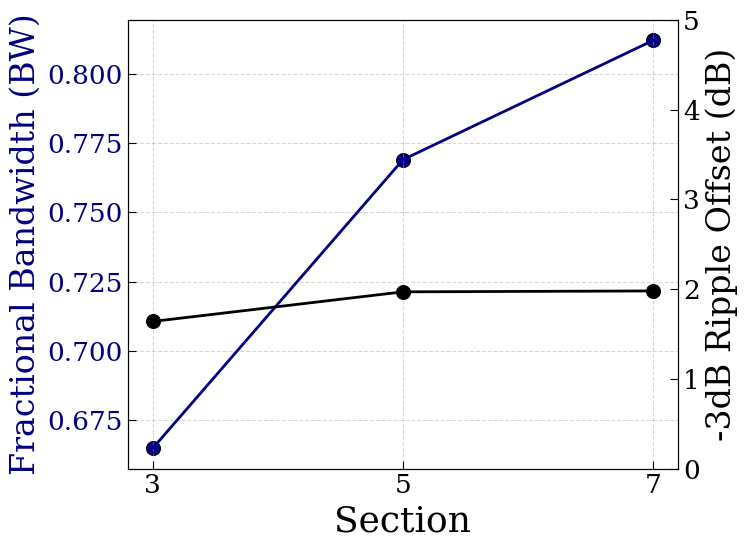

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set font globally to DejaVu Serif and font size
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.size'] = 24  # Set the default font size

# Data
data = {
    'Section': [3, 5, 7],
    'BW': bw,
    'Ripple': ripple
}

df = pd.DataFrame(data)

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(8, 6))

# Primary y-axis for BW
sns.scatterplot(data=df, x='Section', y='BW', ax=ax1, color='navy', s=100, edgecolor='black')
sns.lineplot(data=df, x='Section', y='BW', ax=ax1, color='navy', linestyle='-', linewidth=2)

ax1.set_xlabel("Section", fontsize=26)
ax1.set_ylabel("Fractional Bandwidth (BW)", fontsize=24, color='navy')
ax1.tick_params(axis='y', labelcolor='navy', direction='in', length=6)
ax1.set_xticks(df['Section'])  # Only 3, 5, 7 as xtick labels
ax1.tick_params(axis='x', direction='in', length=6)

# Secondary y-axis for Ripple
ax2 = ax1.twinx()
sns.scatterplot(data=df, x='Section', y='Ripple', ax=ax2, color='black', s=100, edgecolor='black')
sns.lineplot(data=df, x='Section', y='Ripple', ax=ax2, color='black', linestyle='-', linewidth=2)

ax2.set_ylabel("-3dB Ripple Offset (dB)", fontsize=24, color='black')
ax2.tick_params(axis='y', labelcolor='black', direction='in', length=6)
ax2.set_ylim(0, 5)

# Borders
for spine in ax1.spines.values():
    spine.set_edgecolor('black')
for spine in ax2.spines.values():
    spine.set_edgecolor('black')

# Title and grid
#ax1.set_title("Effect of Section on Bandwidth and Ripple", fontsize=28, fontweight='bold')
ax1.grid(True, linestyle='--', alpha=0.5)

# Adding legends
# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()
